In [1]:
print(1)

1


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tqdm import tqdm 
from tensorflow.keras import layers, models
from pathlib import Path

In [3]:
from sklearn.model_selection import train_test_split

In [4]:
# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Parameters
spectrogram_dir = '/kaggle/input/spectograms'
image_size = (64, 64) 

In [5]:
# Step 1: Load spectrograms and labels (from your previous code)
def load_spectrograms_from_subfolders(spectrogram_dir):
    X, Y, spectrogram_paths = [], [], []
    total_files = sum(len(files) for _, _, files in os.walk(spectrogram_dir) if any(f.endswith('.png') for f in files))
    
    with tqdm(total=total_files, desc="Loading Spectrograms") as pbar:
        for label in os.listdir(spectrogram_dir):
            label_dir = os.path.join(spectrogram_dir, label)
            if os.path.isdir(label_dir):
                for file_name in os.listdir(label_dir):
                    if file_name.endswith('.png'):
                        file_path = os.path.join(label_dir, file_name)
                        img = plt.imread(file_path)
                        if len(img.shape) == 3:
                            img = np.mean(img[:, :, :3], axis=-1)
                        elif len(img.shape) == 2:
                            img = img
                        else:
                            continue
                        img = tf.image.resize(img[..., np.newaxis], image_size).numpy()
                        X.append(img)
                        Y.append(label)
                        spectrogram_paths.append(file_path)
                        pbar.update(1)
    
    return np.array(X), np.array(Y), spectrogram_paths

In [6]:
X, Y, spectrogram_paths = load_spectrograms_from_subfolders(spectrogram_dir)
print(f"Loaded {len(X)} spectrograms with shape {X.shape}")
print(f"Classes found: {list(set(Y))}")

# Step 2: Extract features for KMeans clustering
spectrogram_features = X.reshape(X.shape[0], -1)  # Flatten for KMeans

Loading Spectrograms: 100%|██████████| 5477/5477 [03:47<00:00, 24.08it/s]

Loaded 5477 spectrograms with shape (5477, 64, 64, 1)
Classes found: ['Tomato Cut', 'Tobacco Cut', 'Greenhouse Noises', 'Tobacco Dry', 'Tomato Dry', 'Empty Pot']


In [7]:
# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Define paths and parameters
spectrogram_dir = "/kaggle/input/spectograms"  # Directory containing spectrogram subdirectories
n_clusters = 10  # Number of clusters for K-Means
input_shape = (64, 64, 1)  # Input shape for CNN (height, width, channels)

# Step 1: Load spectrogram file paths and labels from subdirectories
def find_image_files_and_labels(directory):
    image_extensions = ('.jpg', '.jpeg', '.png', '.JPG', '.JPEG', '.PNG', '.bmp', '.BMP')
    image_paths = []
    labels = []
    for root, dirs, files in os.walk(directory):
        # Extract the class label from the subdirectory name
        # e.g., "/kaggle/input/spectograms/stressed" -> "stressed"
        label = os.path.basename(root)
        if label == os.path.basename(directory):  # Skip the top-level directory
            continue
        for fname in files:
            if any(fname.endswith(ext) for ext in image_extensions):
                image_paths.append(os.path.join(root, fname))
                labels.append(label)
    return image_paths, labels

spectrogram_paths, labels = find_image_files_and_labels(spectrogram_dir)

# Verify that files were found
print(f"Number of spectrogram files found: {len(spectrogram_paths)}")
if not spectrogram_paths:
    raise ValueError(f"No valid image files found in directory or subdirectories: {spectrogram_dir}")
else:
    print("First few files:", spectrogram_paths[:5])
    print("First few labels:", labels[:5])

# Convert labels to a NumPy array
Y = np.array(labels)

# Encode labels
label_encoder = LabelEncoder()
Y_encoded = label_encoder.fit_transform(Y)
Y_categorical = tf.keras.utils.to_categorical(Y_encoded)
num_classes = Y_categorical.shape[1]  # Number of unique classes
print(f"Number of classes: {num_classes}")
print(f"Class names: {label_encoder.classes_}")

Number of spectrogram files found: 5477
First few files: ['/kaggle/input/spectograms/Tomato Cut/id_133_sound_12.png', '/kaggle/input/spectograms/Tomato Cut/id_203_sound_32.png', '/kaggle/input/spectograms/Tomato Cut/id_183_sound_7.png', '/kaggle/input/spectograms/Tomato Cut/id_193_sound_17.png', '/kaggle/input/spectograms/Tomato Cut/id_197_sound_17.png']
First few labels: ['Tomato Cut', 'Tomato Cut', 'Tomato Cut', 'Tomato Cut', 'Tomato Cut']
Number of classes: 6
Class names: ['Empty Pot' 'Greenhouse Noises' 'Tobacco Cut' 'Tobacco Dry' 'Tomato Cut'
 'Tomato Dry']


n_clusters: 6


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


X_train shape: (4381, 64, 64, 1)
Y_train shape: (4381, 6)
cluster_train shape: (4381, 6)
X_test shape: (1096, 64, 64, 1)
Y_test shape: (1096, 6)
cluster_test shape: (1096, 6)
Epoch 1/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - classification_output_accuracy: 0.3733 - classification_output_loss: 1.6105 - clustering_output_accuracy: 0.2803 - clustering_output_loss: 0.1652 - loss: 3.8753 - val_classification_output_accuracy: 0.7172 - val_classification_output_loss: 0.9852 - val_clustering_output_accuracy: 0.5100 - val_clustering_output_loss: 0.1017 - val_loss: 1.4447
Epoch 2/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - classification_output_accuracy: 0.5884 - classification_output_loss: 1.1755 - clustering_output_accuracy: 0.5580 - clustering_output_loss: 0.1025 - loss: 1.5816 - val_classification_output_accuracy: 0.6980 - val_classification_output_loss: 0.8629 - val_clustering_output_accuracy: 0.5703 - val_clustering_output_loss: 0.0943 - val_loss: 1.1672
Epoch 3/20
136/136 ━━━━━━━

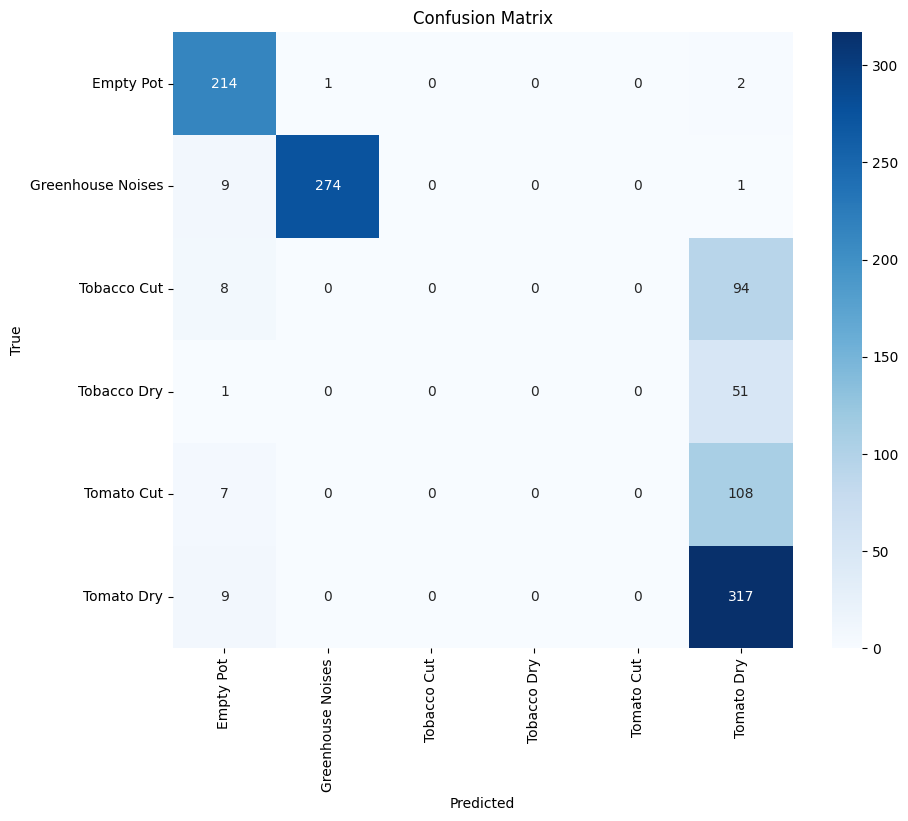

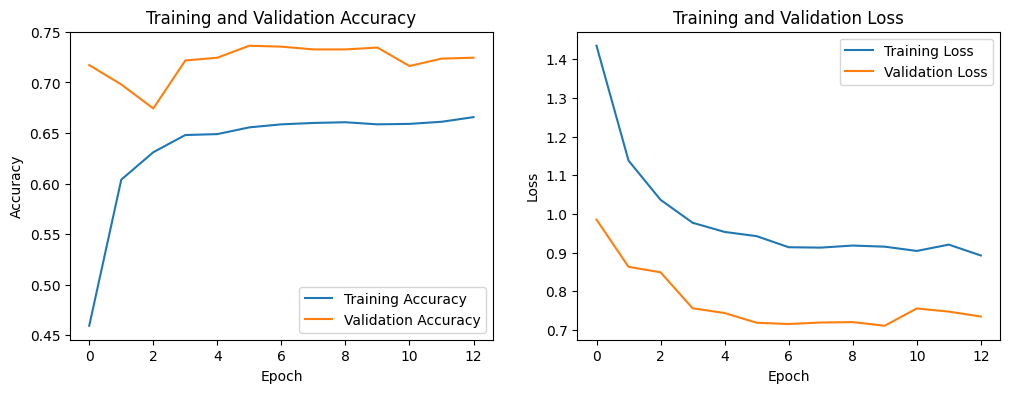

In [8]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Data loading
root_dir = '/kaggle/input/spectograms'
class_names = ['Empty Pot', 'Greenhouse Noises', 'Tobacco Cut', 'Tobacco Dry', 'Tomato Cut', 'Tomato Dry']
spectrogram_paths = []
Y = []

# Load paths and labels based on directory structure
for idx, class_name in enumerate(class_names):
    class_path = os.path.join(root_dir, class_name)
    for root, _, files in os.walk(class_path):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                spectrogram_paths.append(os.path.join(root, file))
                Y.append(idx)

Y = np.array(Y)
# One-hot encode labels
Y_categorical = tf.keras.utils.to_categorical(Y, num_classes=len(class_names))
label_encoder = {i: name for i, name in enumerate(class_names)}

# Step 1: Data Augmentation Setup
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Step 2: Load spectrograms and extract features for clustering
def load_spectrogram_image(file_path):
    try:
        img = plt.imread(file_path)
        if img.size == 0:
            raise ValueError(f"Empty image loaded from {file_path}")
        if len(img.shape) == 3:
            if img.shape[-1] in [3, 4]:
                img = np.mean(img, axis=-1)
        img = np.expand_dims(img, axis=-1)
        img = tf.image.resize(img, [64, 64]).numpy()
        return img.flatten()
    except Exception as e:
        print(f"Error loading image {file_path}: {e}")
        return None

# Extract features from spectrograms
spectrogram_features = []
valid_paths = []
valid_indices = []
for idx, path in enumerate(spectrogram_paths):
    features = load_spectrogram_image(path)
    if features is not None:
        spectrogram_features.append(features)
        valid_paths.append(path)
        valid_indices.append(idx)

spectrogram_features = np.array(spectrogram_features)
if spectrogram_features.size == 0:
    raise ValueError("No valid spectrogram features extracted")

# Update spectrogram_paths and labels to only include valid files
spectrogram_paths = valid_paths
Y = Y[valid_indices]
Y_categorical = Y_categorical[valid_indices]

# Step 3: Apply K-Means clustering
n_clusters = 6  # Set to 6 to match the number of classes
print(f"n_clusters: {n_clusters}")
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(spectrogram_features)

# Convert cluster labels to one-hot encoding for clustering loss
cluster_labels_categorical = tf.keras.utils.to_categorical(cluster_labels, num_classes=n_clusters)

# Step 4: Load spectrograms for CNN (not flattened)
def load_spectrogram_for_cnn(file_path):
    try:
        img = plt.imread(file_path)
        if img.size == 0:
            raise ValueError(f"Empty image loaded from {file_path}")
        if len(img.shape) == 3:
            if img.shape[-1] in [3, 4]:
                img = np.mean(img, axis=-1)
        img = np.expand_dims(img, axis=-1)
        img = tf.image.resize(img, [64, 64]).numpy()
        return img
    except Exception as e:
        print(f"Error loading image {file_path}: {e}")
        return None

# Load all spectrograms
X_spectrograms = []
valid_indices = []
for idx, path in enumerate(spectrogram_paths):
    img = load_spectrogram_for_cnn(path)
    if img is not None:
        X_spectrograms.append(img)
        valid_indices.append(idx)

X_spectrograms = np.array(X_spectrograms)
if X_spectrograms.size == 0:
    raise ValueError("No valid spectrograms loaded for CNN")

# Update labels to match the valid spectrograms
Y_categorical = Y_categorical[valid_indices]
cluster_labels_categorical = cluster_labels_categorical[valid_indices]

# Step 5: Split data into training and testing sets
X_train, X_test, Y_train, Y_test, cluster_train, cluster_test = train_test_split(
    X_spectrograms, Y_categorical, cluster_labels_categorical, test_size=0.2, random_state=42
)

# Normalize the spectrogram images
X_train = (X_train - X_train.mean()) / (X_train.std() + 1e-10)
X_test = (X_test - X_test.mean()) / (X_test.std() + 1e-10)

# Debug: Print shapes
print(f"X_train shape: {X_train.shape}")
print(f"Y_train shape: {Y_train.shape}")
print(f"cluster_train shape: {cluster_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"Y_test shape: {Y_test.shape}")
print(f"cluster_test shape: {cluster_test.shape}")

# Step 6: Build the CNN model with clustering integration
def build_cnn_model_with_clustering(input_shape, num_classes, n_clusters):
    inputs = layers.Input(shape=input_shape)
    
    # CNN layers
    x = layers.Conv2D(32, (3, 3), activation='relu',
                      kernel_regularizer=tf.keras.regularizers.l2(0.01))(inputs)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Conv2D(64, (3, 3), activation='relu',
                      kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Conv2D(128, (3, 3), activation='relu',
                      kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Flatten()(x)
    
    # Extract features for clustering
    clustering_features = layers.Dense(128, activation='relu',
                                       kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    
    # Classification output
    classification_output = layers.Dropout(0.5)(clustering_features)
    classification_output = layers.Dense(num_classes, activation='softmax',
                                        name='classification_output')(classification_output)
    
    # Clustering output (soft assignment)
    clustering_output = layers.Dense(n_clusters, activation='softmax',
                                     name='clustering_output')(clustering_features)
    
    model = models.Model(inputs=inputs, outputs=[classification_output, clustering_output])
    return model

# Build and compile the model with dual loss
input_shape = (64, 64, 1)
num_classes = 6
model = build_cnn_model_with_clustering(input_shape, num_classes, n_clusters)
model.compile(
    optimizer='adam',
    loss={
        'classification_output': 'categorical_crossentropy',
        'clustering_output': 'categorical_crossentropy'
    },
    loss_weights={
        'classification_output': 1.0,
        'clustering_output': 0.1
    },
    metrics={
        'classification_output': 'accuracy',
        'clustering_output': 'accuracy'
    }
)

# Step 7: Fixed Data Generator
def data_generator(X, Y, cluster_labels, batch_size, datagen, shuffle=True):
    num_samples = len(X)
    indices = np.arange(num_samples)
    while True:
        if shuffle:
            np.random.shuffle(indices)
        
        for start_idx in range(0, num_samples, batch_size):
            batch_indices = indices[start_idx:start_idx + batch_size]
            
            # Ensure the batch size is consistent
            if len(batch_indices) < batch_size and start_idx + batch_size <= num_samples:
                continue  # Skip incomplete batches to avoid shape issues
            
            X_batch = X[batch_indices]
            Y_batch = Y[batch_indices]
            cluster_batch = cluster_labels[batch_indices]
            
            # Apply augmentation to X_batch
            X_batch_aug = np.zeros_like(X_batch)
            for i in range(len(X_batch)):
                X_batch_aug[i] = datagen.random_transform(X_batch[i])
            
            yield X_batch_aug, {'classification_output': Y_batch, 'clustering_output': cluster_batch}

# Train the model
batch_size = 32
steps_per_epoch = (len(X_train) // batch_size) or 1  # Ensure at least 1 step
history = model.fit(
    data_generator(X_train, Y_train, cluster_train, batch_size, datagen),
    steps_per_epoch=steps_per_epoch,
    epochs=20,
    validation_data=(X_test, {'classification_output': Y_test, 'clustering_output': cluster_test}),
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_classification_output_loss',
            patience=3,
            restore_best_weights=True,
            mode='min'
        )
    ]
)

# Step 8: Evaluate the model (only classification output)
print(f"Model metrics names: {model.metrics_names}")  # Debug: Print metric names
test_results = model.evaluate(
    X_test,
    {'classification_output': Y_test, 'clustering_output': cluster_test},
    verbose=0
)
# Fallback method to find classification accuracy
classification_output_idx = None
for i, metric_name in enumerate(model.metrics_names):
    if 'classification_output' in metric_name and 'loss' in metric_name:
        classification_output_idx = i + 1  # Accuracy typically follows loss
        break

if classification_output_idx is not None and classification_output_idx < len(test_results):
    test_accuracy = test_results[classification_output_idx]
    print(f"Test Accuracy: {test_accuracy:.4f}")
else:
    raise ValueError(f"Could not determine classification output accuracy from {model.metrics_names}. Check metric names.")

# Step 9: Generate predictions for confusion matrix (classification output)
Y_pred, _ = model.predict(X_test)
Y_pred_classes = np.argmax(Y_pred, axis=1)
Y_test_classes = np.argmax(Y_test, axis=1)

# Compute confusion matrix
cm = confusion_matrix(Y_test_classes, Y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Plot training and validation accuracy/loss
plt.figure(figsize=(12, 4))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['classification_output_accuracy'], label='Training Accuracy')
plt.plot(history.history['val_classification_output_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['classification_output_loss'], label='Training Loss')
plt.plot(history.history['val_classification_output_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.show()

n_clusters: 6


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


X_train shape: (4381, 64, 64, 1)
Y_train shape: (4381, 6)
cluster_train shape: (4381, 6)
X_test shape: (1096, 64, 64, 1)
Y_test shape: (1096, 6)
cluster_test shape: (1096, 6)
Epoch 1/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - classification_output_accuracy: 0.3242 - classification_output_loss: 1.6952 - clustering_output_accuracy: 0.2943 - clustering_output_loss: 0.1703 - loss: 4.1614 - val_classification_output_accuracy: 0.5292 - val_classification_output_loss: 1.2252 - val_clustering_output_accuracy: 0.4224 - val_clustering_output_loss: 0.1290 - val_loss: 1.8075
Epoch 2/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - classification_output_accuracy: 0.5642 - classification_output_loss: 1.1871 - clustering_output_accuracy: 0.5082 - clustering_output_loss: 0.1120 - loss: 1.6611 - val_classification_output_accuracy: 0.7245 - val_classification_output_loss: 0.9264 - val_clustering_output_accuracy: 0.7062 - val_clustering_output_loss: 0.0935 - val_loss: 1.2467
Epoch 3/20
136/136 ━━━━━━━━

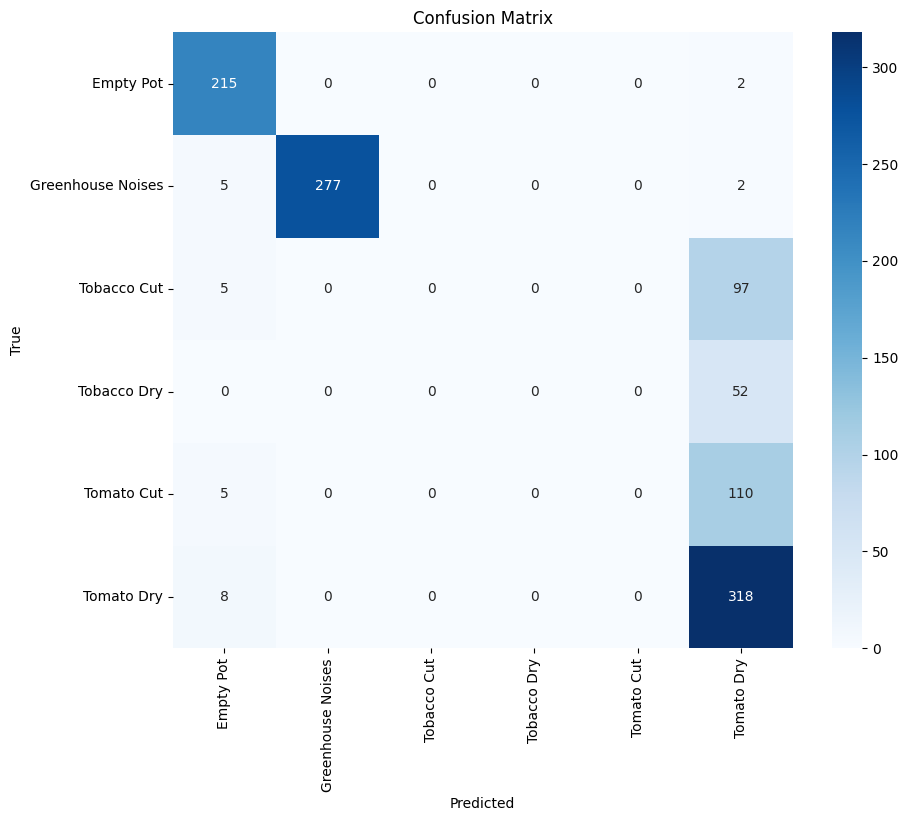

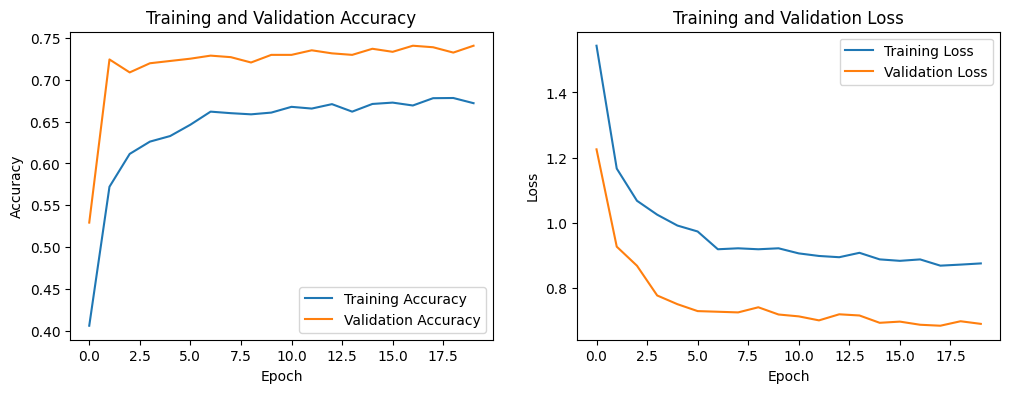

In [9]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Data loading
root_dir = '/kaggle/input/spectograms'
class_names = ['Empty Pot', 'Greenhouse Noises', 'Tobacco Cut', 'Tobacco Dry', 'Tomato Cut', 'Tomato Dry']
spectrogram_paths = []
Y = []

# Load paths and labels based on directory structure
for idx, class_name in enumerate(class_names):
    class_path = os.path.join(root_dir, class_name)
    for root, _, files in os.walk(class_path):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                spectrogram_paths.append(os.path.join(root, file))
                Y.append(idx)

Y = np.array(Y)
# One-hot encode labels
Y_categorical = tf.keras.utils.to_categorical(Y, num_classes=len(class_names))
label_encoder = {i: name for i, name in enumerate(class_names)}

# Step 1: Data Augmentation Setup
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Step 2: Load spectrograms and extract features for clustering
def load_spectrogram_image(file_path):
    try:
        img = plt.imread(file_path)
        if img.size == 0:
            raise ValueError(f"Empty image loaded from {file_path}")
        if len(img.shape) == 3:
            if img.shape[-1] in [3, 4]:
                img = np.mean(img, axis=-1)
        img = np.expand_dims(img, axis=-1)
        img = tf.image.resize(img, [64, 64]).numpy()
        return img.flatten()
    except Exception as e:
        print(f"Error loading image {file_path}: {e}")
        return None

# Extract features from spectrograms
spectrogram_features = []
valid_paths = []
valid_indices = []
for idx, path in enumerate(spectrogram_paths):
    features = load_spectrogram_image(path)
    if features is not None:
        spectrogram_features.append(features)
        valid_paths.append(path)
        valid_indices.append(idx)

spectrogram_features = np.array(spectrogram_features)
if spectrogram_features.size == 0:
    raise ValueError("No valid spectrogram features extracted")

# Update spectrogram_paths and labels to only include valid files
spectrogram_paths = valid_paths
Y = Y[valid_indices]
Y_categorical = Y_categorical[valid_indices]

# Step 3: Apply K-Means clustering
n_clusters = 6  # Set to 6 to match the number of classes
print(f"n_clusters: {n_clusters}")
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(spectrogram_features)

# Convert cluster labels to one-hot encoding for clustering loss
cluster_labels_categorical = tf.keras.utils.to_categorical(cluster_labels, num_classes=n_clusters)

# Step 4: Load spectrograms for CNN (not flattened)
def load_spectrogram_for_cnn(file_path):
    try:
        img = plt.imread(file_path)
        if img.size == 0:
            raise ValueError(f"Empty image loaded from {file_path}")
        if len(img.shape) == 3:
            if img.shape[-1] in [3, 4]:
                img = np.mean(img, axis=-1)
        img = np.expand_dims(img, axis=-1)
        img = tf.image.resize(img, [64, 64]).numpy()
        return img
    except Exception as e:
        print(f"Error loading image {file_path}: {e}")
        return None

# Load all spectrograms
X_spectrograms = []
valid_indices = []
for idx, path in enumerate(spectrogram_paths):
    img = load_spectrogram_for_cnn(path)
    if img is not None:
        X_spectrograms.append(img)
        valid_indices.append(idx)

X_spectrograms = np.array(X_spectrograms)
if X_spectrograms.size == 0:
    raise ValueError("No valid spectrograms loaded for CNN")

# Update labels to match the valid spectrograms
Y_categorical = Y_categorical[valid_indices]
cluster_labels_categorical = cluster_labels_categorical[valid_indices]

# Step 5: Split data into training and testing sets
X_train, X_test, Y_train, Y_test, cluster_train, cluster_test = train_test_split(
    X_spectrograms, Y_categorical, cluster_labels_categorical, test_size=0.2, random_state=42
)

# Normalize the spectrogram images
X_train = (X_train - X_train.mean()) / (X_train.std() + 1e-10)
X_test = (X_test - X_test.mean()) / (X_test.std() + 1e-10)

# Debug: Print shapes
print(f"X_train shape: {X_train.shape}")
print(f"Y_train shape: {Y_train.shape}")
print(f"cluster_train shape: {cluster_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"Y_test shape: {Y_test.shape}")
print(f"cluster_test shape: {cluster_test.shape}")

# Step 6: Build the CNN model with clustering integration
def build_cnn_model_with_clustering(input_shape, num_classes, n_clusters):
    inputs = layers.Input(shape=input_shape)
    
    # CNN layers
    x = layers.Conv2D(32, (3, 3), activation='relu',
                      kernel_regularizer=tf.keras.regularizers.l2(0.01))(inputs)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Conv2D(64, (3, 3), activation='relu',
                      kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Conv2D(128, (3, 3), activation='relu',
                      kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Flatten()(x)
    
    # Extract features for clustering
    clustering_features = layers.Dense(128, activation='relu',
                                       kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    
    # Classification output
    classification_output = layers.Dropout(0.5)(clustering_features)
    classification_output = layers.Dense(num_classes, activation='softmax',
                                        name='classification_output')(classification_output)
    
    # Clustering output (soft assignment)
    clustering_output = layers.Dense(n_clusters, activation='softmax',
                                     name='clustering_output')(clustering_features)
    
    model = models.Model(inputs=inputs, outputs=[classification_output, clustering_output])
    return model

# Build and compile the model with dual loss
input_shape = (64, 64, 1)
num_classes = 6
model = build_cnn_model_with_clustering(input_shape, num_classes, n_clusters)
model.compile(
    optimizer='adam',
    loss={
        'classification_output': 'categorical_crossentropy',
        'clustering_output': 'categorical_crossentropy'
    },
    loss_weights={
        'classification_output': 1.0,
        'clustering_output': 0.1
    },
    metrics={
        'classification_output': ['accuracy'],  # Explicitly specify as list
        'clustering_output': ['accuracy']
    }
)

# Step 7: Fixed Data Generator
def data_generator(X, Y, cluster_labels, batch_size, datagen, shuffle=True):
    num_samples = len(X)
    indices = np.arange(num_samples)
    while True:
        if shuffle:
            np.random.shuffle(indices)
        
        for start_idx in range(0, num_samples, batch_size):
            batch_indices = indices[start_idx:start_idx + batch_size]
            
            # Ensure the batch size is consistent
            if len(batch_indices) < batch_size and start_idx + batch_size <= num_samples:
                continue  # Skip incomplete batches to avoid shape issues
            
            X_batch = X[batch_indices]
            Y_batch = Y[batch_indices]
            cluster_batch = cluster_labels[batch_indices]
            
            # Apply augmentation to X_batch
            X_batch_aug = np.zeros_like(X_batch)
            for i in range(len(X_batch)):
                X_batch_aug[i] = datagen.random_transform(X_batch[i])
            
            yield X_batch_aug, {'classification_output': Y_batch, 'clustering_output': cluster_batch}

# Train the model
batch_size = 32
steps_per_epoch = (len(X_train) // batch_size) or 1  # Ensure at least 1 step
history = model.fit(
    data_generator(X_train, Y_train, cluster_train, batch_size, datagen),
    steps_per_epoch=steps_per_epoch,
    epochs=20,
    validation_data=(X_test, {'classification_output': Y_test, 'clustering_output': cluster_test}),
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_classification_output_loss',
            patience=3,
            restore_best_weights=True,
            mode='min'
        )
    ]
)

# Compute cumulative training and validation accuracy
cumulative_train_accuracy = np.mean(history.history['classification_output_accuracy'])
cumulative_val_accuracy = np.mean(history.history['val_classification_output_accuracy'])
print(f"Cumulative Training Accuracy (across epochs): {cumulative_train_accuracy:.4f}")
print(f"Cumulative Validation Accuracy (across epochs): {cumulative_val_accuracy:.4f}")

# Step 8: Evaluate the model (only classification output)
print(f"Model metrics names: {model.metrics_names}")  # Debug: Print metric names
test_results = model.evaluate(
    X_test,
    {'classification_output': Y_test, 'clustering_output': cluster_test},
    verbose=0
)
# Fallback method to find classification accuracy
classification_output_idx = None
for i, metric_name in enumerate(model.metrics_names):
    if 'classification_output' in metric_name and 'loss' in metric_name:
        classification_output_idx = i + 1  # Accuracy typically follows loss
        break

if classification_output_idx is not None and classification_output_idx < len(test_results):
    test_accuracy = test_results[classification_output_idx]
    print(f"Test Accuracy (cumulative over test set): {test_accuracy:.4f}")
else:
    raise ValueError(f"Could not determine classification output accuracy from {model.metrics_names}. Check metric names.")

# Step 9: Generate predictions for confusion matrix (classification output)
Y_pred, _ = model.predict(X_test)
Y_pred_classes = np.argmax(Y_pred, axis=1)
Y_test_classes = np.argmax(Y_test, axis=1)

# Compute confusion matrix
cm = confusion_matrix(Y_test_classes, Y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Plot training and validation accuracy/loss
plt.figure(figsize=(12, 4))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['classification_output_accuracy'], label='Training Accuracy')
plt.plot(history.history['val_classification_output_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['classification_output_loss'], label='Training Loss')
plt.plot(history.history['val_classification_output_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.show()

n_clusters: 6


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


X_train shape: (4381, 64, 64, 1)
Y_train shape: (4381, 6)
cluster_train shape: (4381, 6)
X_test shape: (1096, 64, 64, 1)
Y_test shape: (1096, 6)
cluster_test shape: (1096, 6)
Epoch 1/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - classification_output_accuracy: 0.3475 - classification_output_loss: 1.6242 - clustering_output_accuracy: 0.3218 - clustering_output_loss: 0.1662 - loss: 3.9735 - val_classification_output_accuracy: 0.6597 - val_classification_output_loss: 1.0558 - val_clustering_output_accuracy: 0.5529 - val_clustering_output_loss: 0.1130 - val_loss: 1.5781
Epoch 2/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - classification_output_accuracy: 0.5814 - classification_output_loss: 1.1197 - clustering_output_accuracy: 0.5548 - clustering_output_loss: 0.1034 - loss: 1.5608 - val_classification_output_accuracy: 0.7172 - val_classification_output_loss: 0.7711 - val_clustering_output_accuracy: 0.6186 - val_clustering_output_loss: 0.0868 - val_loss: 1.0920
Epoch 3/20
136/136 ━━━━━━━━

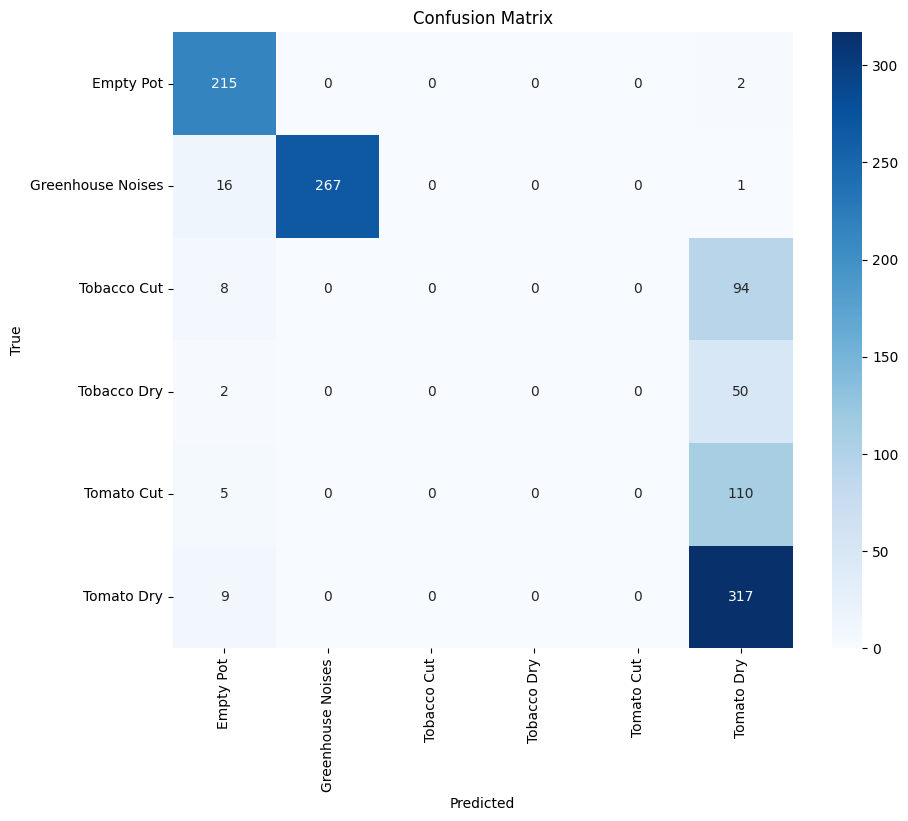

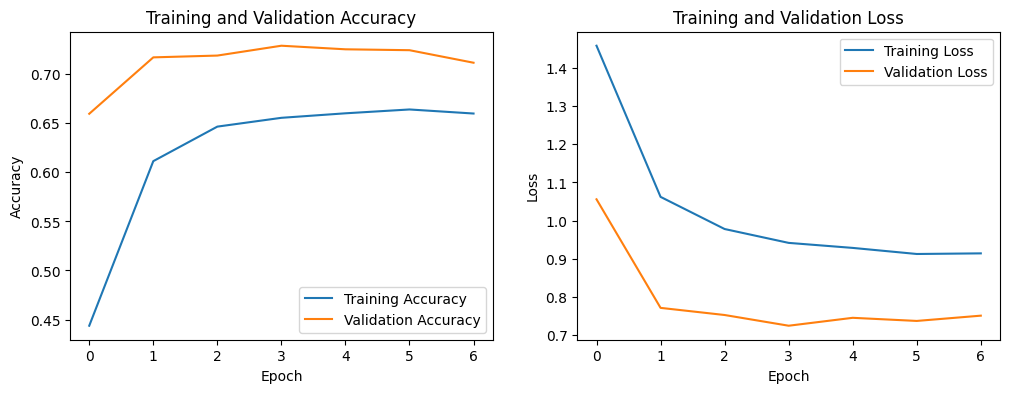

In [10]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Data loading
root_dir = '/kaggle/input/spectograms'
class_names = ['Empty Pot', 'Greenhouse Noises', 'Tobacco Cut', 'Tobacco Dry', 'Tomato Cut', 'Tomato Dry']
spectrogram_paths = []
Y = []

for idx, class_name in enumerate(class_names):
    class_path = os.path.join(root_dir, class_name)
    for root, _, files in os.walk(class_path):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                spectrogram_paths.append(os.path.join(root, file))
                Y.append(idx)

Y = np.array(Y)
Y_categorical = tf.keras.utils.to_categorical(Y, num_classes=len(class_names))
label_encoder = {i: name for i, name in enumerate(class_names)}

# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Load features for clustering with denoising
def load_spectrogram_image(file_path):
    try:
        img = plt.imread(file_path)
        if img.size == 0:
            raise ValueError(f"Empty image loaded from {file_path}")
        if len(img.shape) == 3 and img.shape[-1] in [3, 4]:
            img = np.mean(img, axis=-1)
        img = np.expand_dims(img, axis=-1)
        img = tf.image.resize(img, [64, 64]).numpy()
        # Denoise for clustering consistency
        threshold = 0.02 * img.max()
        img[img < threshold] = 0
        return img.flatten()
    except Exception as e:
        print(f"Error loading image {file_path}: {e}")
        return None

spectrogram_features = []
valid_paths = []
valid_indices = []
for idx, path in enumerate(spectrogram_paths):
    features = load_spectrogram_image(path)
    if features is not None:
        spectrogram_features.append(features)
        valid_paths.append(path)
        valid_indices.append(idx)

spectrogram_features = np.array(spectrogram_features)
if spectrogram_features.size == 0:
    raise ValueError("No valid spectrogram features extracted")

spectrogram_paths = valid_paths
Y = Y[valid_indices]
Y_categorical = Y_categorical[valid_indices]

# K-Means clustering
n_clusters = 6
print(f"n_clusters: {n_clusters}")
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(spectrogram_features)
cluster_labels_categorical = tf.keras.utils.to_categorical(cluster_labels, num_classes=n_clusters)

# Load spectrograms for CNN with adjusted denoising
def load_spectrogram_for_cnn(file_path):
    try:
        img = plt.imread(file_path)
        if img.size == 0:
            raise ValueError(f"Empty image loaded from {file_path}")
        if len(img.shape) == 3 and img.shape[-1] in [3, 4]:
            img = np.mean(img, axis=-1)
        img = np.expand_dims(img, axis=-1)
        img = tf.image.resize(img, [64, 64]).numpy()
        # Adjusted denoising
        threshold = 0.02 * img.max()
        img[img < threshold] = 0
        return img
    except Exception as e:
        print(f"Error loading image {file_path}: {e}")
        return None

X_spectrograms = []
valid_indices = []
for idx, path in enumerate(spectrogram_paths):
    img = load_spectrogram_for_cnn(path)
    if img is not None:
        X_spectrograms.append(img)
        valid_indices.append(idx)

X_spectrograms = np.array(X_spectrograms)
if X_spectrograms.size == 0:
    raise ValueError("No valid spectrograms loaded for CNN")

Y_categorical = Y_categorical[valid_indices]
cluster_labels_categorical = cluster_labels_categorical[valid_indices]

# Split data
X_train, X_test, Y_train, Y_test, cluster_train, cluster_test = train_test_split(
    X_spectrograms, Y_categorical, cluster_labels_categorical, test_size=0.2, random_state=42
)

# Global normalization (reintroduced)
X_train = (X_train - X_train.mean()) / (X_train.std() + 1e-10)
X_test = (X_test - X_test.mean()) / (X_test.std() + 1e-10)

# Debug shapes
print(f"X_train shape: {X_train.shape}")
print(f"Y_train shape: {Y_train.shape}")
print(f"cluster_train shape: {cluster_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"Y_test shape: {Y_test.shape}")
print(f"cluster_test shape: {cluster_test.shape}")

# Build CNN model
def build_cnn_model_with_clustering(input_shape, num_classes, n_clusters):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(inputs)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Flatten()(x)
    clustering_features = layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    classification_output = layers.Dropout(0.5)(clustering_features)
    classification_output = layers.Dense(num_classes, activation='softmax', name='classification_output')(classification_output)
    clustering_output = layers.Dense(n_clusters, activation='softmax', name='clustering_output')(clustering_features)
    return models.Model(inputs=inputs, outputs=[classification_output, clustering_output])

input_shape = (64, 64, 1)
num_classes = 6
model = build_cnn_model_with_clustering(input_shape, num_classes, n_clusters)
model.compile(
    optimizer='adam',
    loss={'classification_output': 'categorical_crossentropy', 'clustering_output': 'categorical_crossentropy'},
    loss_weights={'classification_output': 1.0, 'clustering_output': 0.1},
    metrics={'classification_output': [tf.keras.metrics.CategoricalAccuracy(name='accuracy')],
             'clustering_output': [tf.keras.metrics.CategoricalAccuracy(name='accuracy')]}
)

# Data Generator
def data_generator(X, Y, cluster_labels, batch_size, datagen, shuffle=True):
    num_samples = len(X)
    indices = np.arange(num_samples)
    while True:
        if shuffle:
            np.random.shuffle(indices)
        for start_idx in range(0, num_samples, batch_size):
            batch_indices = indices[start_idx:start_idx + batch_size]
            if len(batch_indices) < batch_size and start_idx + batch_size <= num_samples:
                continue
            X_batch = X[batch_indices]
            Y_batch = Y[batch_indices]
            cluster_batch = cluster_labels[batch_indices]
            X_batch_aug = np.zeros_like(X_batch)
            for i in range(len(X_batch)):
                X_batch_aug[i] = datagen.random_transform(X_batch[i])
            yield X_batch_aug, {'classification_output': Y_batch, 'clustering_output': cluster_batch}

batch_size = 32
steps_per_epoch = (len(X_train) // batch_size) or 1
history = model.fit(
    data_generator(X_train, Y_train, cluster_train, batch_size, datagen),
    steps_per_epoch=steps_per_epoch,
    epochs=20,
    validation_data=(X_test, {'classification_output': Y_test, 'clustering_output': cluster_test}),
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_classification_output_loss', patience=3, restore_best_weights=True, mode='min')]
)

# Compute cumulative accuracies
cumulative_train_accuracy = np.mean(history.history['classification_output_accuracy'])
cumulative_val_accuracy = np.mean(history.history['val_classification_output_accuracy'])
print(f"Cumulative Training Accuracy (across epochs): {cumulative_train_accuracy:.4f}")
print(f"Cumulative Validation Accuracy (across epochs): {cumulative_val_accuracy:.4f}")

# Evaluate and get test accuracy
print(f"Model metrics names: {model.metrics_names}")
test_results = model.evaluate(X_test, {'classification_output': Y_test, 'clustering_output': cluster_test}, verbose=0)
classification_output_idx = None
for i, metric_name in enumerate(model.metrics_names):
    if 'classification_output' in metric_name and 'loss' in metric_name:
        classification_output_idx = i + 1
        break
if classification_output_idx is not None and classification_output_idx < len(test_results):
    test_accuracy = test_results[classification_output_idx]
    print(f"Test Accuracy (cumulative over test set): {test_accuracy:.4f}")
else:
    raise ValueError(f"Could not determine classification output accuracy from {model.metrics_names}.")

# Confusion matrix and plots
Y_pred, _ = model.predict(X_test)
Y_pred_classes = np.argmax(Y_pred, axis=1)
Y_test_classes = np.argmax(Y_test, axis=1)
cm = confusion_matrix(Y_test_classes, Y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['classification_output_accuracy'], label='Training Accuracy')
plt.plot(history.history['val_classification_output_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.subplot(1, 2, 2)
plt.plot(history.history['classification_output_loss'], label='Training Loss')
plt.plot(history.history['val_classification_output_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

n_clusters: 6


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


X_train shape: (4381, 64, 64, 1)
Y_train shape: (4381, 6)
cluster_train shape: (4381, 6)
X_test shape: (1096, 64, 64, 1)
Y_test shape: (1096, 6)
cluster_test shape: (1096, 6)
Epoch 1/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - classification_output_accuracy: 0.3734 - classification_output_loss: 1.6164 - clustering_output_accuracy: 0.2596 - clustering_output_loss: 0.1683 - loss: 3.9387 - val_classification_output_accuracy: 0.6870 - val_classification_output_loss: 1.0074 - val_clustering_output_accuracy: 0.4407 - val_clustering_output_loss: 0.1184 - val_loss: 1.5611
Epoch 2/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - classification_output_accuracy: 0.5929 - classification_output_loss: 1.1463 - clustering_output_accuracy: 0.5038 - clustering_output_loss: 0.1129 - loss: 1.6185 - val_classification_output_accuracy: 0.7080 - val_classification_output_loss: 0.8463 - val_clustering_output_accuracy: 0.5420 - val_clustering_output_loss: 0.0930 - val_loss: 1.1738
Epoch 3/20
136/136 ━━━━━━━━

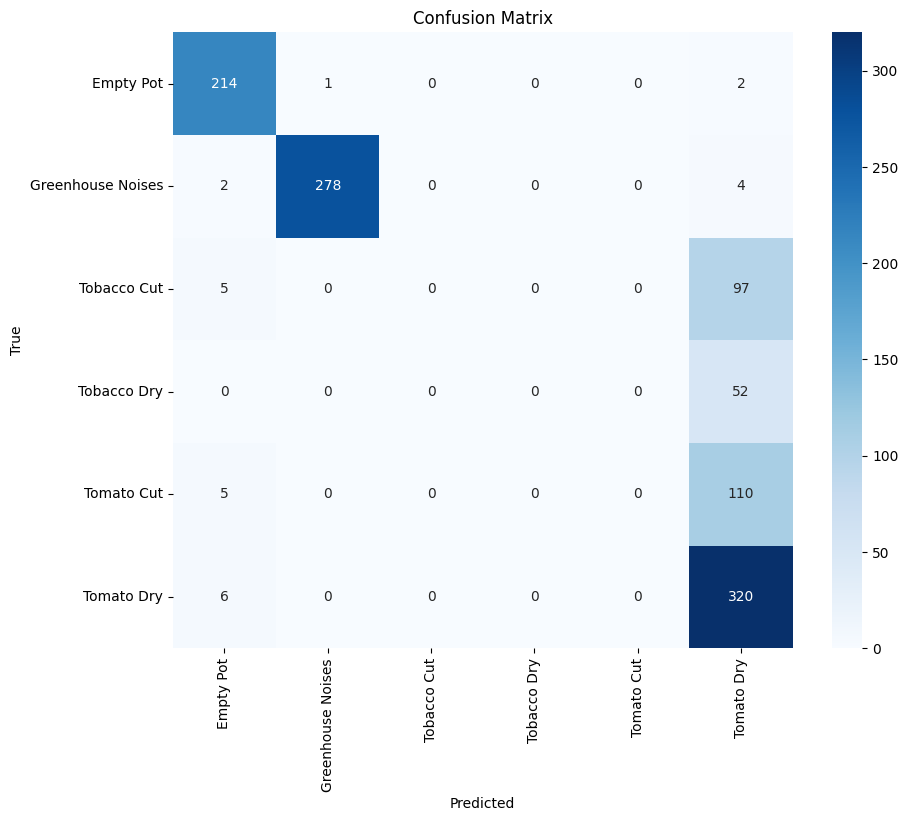

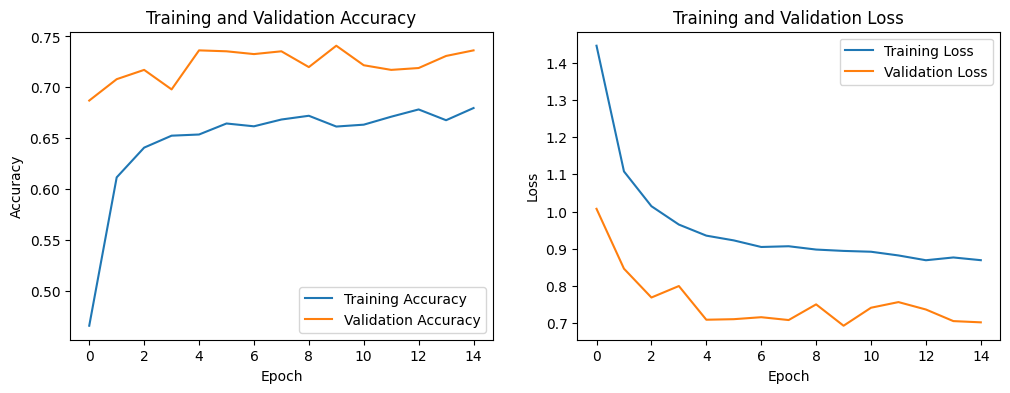

In [11]:
import os
import numpy as np
import random
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

# Data loading
root_dir = '/kaggle/input/spectograms'
class_names = ['Empty Pot', 'Greenhouse Noises', 'Tobacco Cut', 'Tobacco Dry', 'Tomato Cut', 'Tomato Dry']
spectrogram_paths = []
Y = []

for idx, class_name in enumerate(class_names):
    class_path = os.path.join(root_dir, class_name)
    for root, _, files in os.walk(class_path):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                spectrogram_paths.append(os.path.join(root, file))
                Y.append(idx)

Y = np.array(Y)
Y_categorical = tf.keras.utils.to_categorical(Y, num_classes=len(class_names))
label_encoder = {i: name for i, name in enumerate(class_names)}

# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Load features for clustering (no denoising)
def load_spectrogram_image(file_path):
    try:
        img = plt.imread(file_path)
        if img.size == 0:
            raise ValueError(f"Empty image loaded from {file_path}")
        if len(img.shape) == 3 and img.shape[-1] in [3, 4]:
            img = np.mean(img, axis=-1)
        img = np.expand_dims(img, axis=-1)
        img = tf.image.resize(img, [64, 64]).numpy()
        return img.flatten()
    except Exception as e:
        print(f"Error loading image {file_path}: {e}")
        return None

spectrogram_features = []
valid_paths = []
valid_indices = []
for idx, path in enumerate(spectrogram_paths):
    features = load_spectrogram_image(path)
    if features is not None:
        spectrogram_features.append(features)
        valid_paths.append(path)
        valid_indices.append(idx)

spectrogram_features = np.array(spectrogram_features)
if spectrogram_features.size == 0:
    raise ValueError("No valid spectrogram features extracted")

spectrogram_paths = valid_paths
Y = Y[valid_indices]
Y_categorical = Y_categorical[valid_indices]

# K-Means clustering
n_clusters = 6
print(f"n_clusters: {n_clusters}")
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(spectrogram_features)
cluster_labels_categorical = tf.keras.utils.to_categorical(cluster_labels, num_classes=n_clusters)

# Load spectrograms for CNN (no denoising)
def load_spectrogram_for_cnn(file_path):
    try:
        img = plt.imread(file_path)
        if img.size == 0:
            raise ValueError(f"Empty image loaded from {file_path}")
        if len(img.shape) == 3 and img.shape[-1] in [3, 4]:
            img = np.mean(img, axis=-1)
        img = np.expand_dims(img, axis=-1)
        img = tf.image.resize(img, [64, 64]).numpy()
        return img
    except Exception as e:
        print(f"Error loading image {file_path}: {e}")
        return None

X_spectrograms = []
valid_indices = []
for idx, path in enumerate(spectrogram_paths):
    img = load_spectrogram_for_cnn(path)
    if img is not None:
        X_spectrograms.append(img)
        valid_indices.append(idx)

X_spectrograms = np.array(X_spectrograms)
if X_spectrograms.size == 0:
    raise ValueError("No valid spectrograms loaded for CNN")

Y_categorical = Y_categorical[valid_indices]
cluster_labels_categorical = cluster_labels_categorical[valid_indices]

# Split data
X_train, X_test, Y_train, Y_test, cluster_train, cluster_test = train_test_split(
    X_spectrograms, Y_categorical, cluster_labels_categorical, test_size=0.2, random_state=42
)

# Global normalization
X_train = (X_train - X_train.mean()) / (X_train.std() + 1e-10)
X_test = (X_test - X_test.mean()) / (X_test.std() + 1e-10)

# Debug shapes
print(f"X_train shape: {X_train.shape}")
print(f"Y_train shape: {Y_train.shape}")
print(f"cluster_train shape: {cluster_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"Y_test shape: {Y_test.shape}")
print(f"cluster_test shape: {cluster_test.shape}")

# Build CNN model
def build_cnn_model_with_clustering(input_shape, num_classes, n_clusters):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(inputs)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Flatten()(x)
    clustering_features = layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    classification_output = layers.Dropout(0.5)(clustering_features)
    classification_output = layers.Dense(num_classes, activation='softmax', name='classification_output')(classification_output)
    clustering_output = layers.Dense(n_clusters, activation='softmax', name='clustering_output')(clustering_features)
    return models.Model(inputs=inputs, outputs=[classification_output, clustering_output])

input_shape = (64, 64, 1)
num_classes = 6
model = build_cnn_model_with_clustering(input_shape, num_classes, n_clusters)
model.compile(
    optimizer='adam',
    loss={'classification_output': 'categorical_crossentropy', 'clustering_output': 'categorical_crossentropy'},
    loss_weights={'classification_output': 1.0, 'clustering_output': 0.1},
    metrics={'classification_output': ['accuracy'],
             'clustering_output': ['accuracy']}
)

# Data Generator
def data_generator(X, Y, cluster_labels, batch_size, datagen, shuffle=True):
    num_samples = len(X)
    indices = np.arange(num_samples)
    while True:
        if shuffle:
            np.random.shuffle(indices)
        for start_idx in range(0, num_samples, batch_size):
            batch_indices = indices[start_idx:start_idx + batch_size]
            if len(batch_indices) < batch_size and start_idx + batch_size <= num_samples:
                continue
            X_batch = X[batch_indices]
            Y_batch = Y[batch_indices]
            cluster_batch = cluster_labels[batch_indices]
            X_batch_aug = np.zeros_like(X_batch)
            for i in range(len(X_batch)):
                X_batch_aug[i] = datagen.random_transform(X_batch[i])
            yield X_batch_aug, {'classification_output': Y_batch, 'clustering_output': cluster_batch}

batch_size = 32
steps_per_epoch = (len(X_train) // batch_size) or 1
history = model.fit(
    data_generator(X_train, Y_train, cluster_train, batch_size, datagen),
    steps_per_epoch=steps_per_epoch,
    epochs=20,
    validation_data=(X_test, {'classification_output': Y_test, 'clustering_output': cluster_test}),
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_classification_output_loss', patience=5, restore_best_weights=True, mode='min')]
)

# Debug history.history keys
print("Available keys in history.history:", history.history.keys())

# Compute cumulative accuracies with fallback
try:
    cumulative_train_accuracy = np.mean(history.history['classification_output_accuracy'])
    cumulative_val_accuracy = np.mean(history.history['val_classification_output_accuracy'])
except KeyError:
    # Fallback: Check alternative metric names
    possible_train_keys = [key for key in history.history.keys() if 'classification_output' in key and 'accuracy' in key and 'val' not in key]
    possible_val_keys = [key for key in history.history.keys() if 'val_classification_output' in key and 'accuracy' in key]
    if possible_train_keys and possible_val_keys:
        train_key = possible_train_keys[0]
        val_key = possible_val_keys[0]
        print(f"Using alternative metric keys - Training: {train_key}, Validation: {val_key}")
        cumulative_train_accuracy = np.mean(history.history[train_key])
        cumulative_val_accuracy = np.mean(history.history[val_key])
    else:
        # Fallback: Manual evaluation
        print("Manually evaluating training and validation accuracy...")
        train_results = model.evaluate(X_train, {'classification_output': Y_train, 'clustering_output': cluster_train}, verbose=0)
        val_results = model.evaluate(X_test, {'classification_output': Y_test, 'clustering_output': cluster_test}, verbose=0)
        train_accuracy_idx = None
        val_accuracy_idx = None
        for i, metric_name in enumerate(model.metrics_names):
            if 'classification_output' in metric_name and 'loss' in metric_name:
                train_accuracy_idx = i + 1
                val_accuracy_idx = i + 1
                break
        cumulative_train_accuracy = train_results[train_accuracy_idx] if train_accuracy_idx is not None else 0.0
        cumulative_val_accuracy = val_results[val_accuracy_idx] if val_accuracy_idx is not None else 0.0

print(f"Cumulative Training Accuracy (across epochs): {cumulative_train_accuracy:.4f}")
print(f"Cumulative Validation Accuracy (across epochs): {cumulative_val_accuracy:.4f}")

# Evaluate and get test accuracy
print(f"Model metrics names: {model.metrics_names}")
test_results = model.evaluate(X_test, {'classification_output': Y_test, 'clustering_output': cluster_test}, verbose=0)
classification_output_idx = None
for i, metric_name in enumerate(model.metrics_names):
    if 'classification_output' in metric_name and 'loss' in metric_name:
        classification_output_idx = i + 1
        break
if classification_output_idx is not None and classification_output_idx < len(test_results):
    test_accuracy = test_results[classification_output_idx]
    print(f"Test Accuracy (cumulative over test set): {test_accuracy:.4f}")
else:
    raise ValueError(f"Could not determine classification output accuracy from {model.metrics_names}.")

# Confusion matrix and plots
Y_pred, _ = model.predict(X_test)
Y_pred_classes = np.argmax(Y_pred, axis=1)
Y_test_classes = np.argmax(Y_test, axis=1)
cm = confusion_matrix(Y_test_classes, Y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history.get('classification_output_accuracy', history.history.get(list(history.history.keys())[0], [])), label='Training Accuracy')
plt.plot(history.history.get('val_classification_output_accuracy', history.history.get(list(history.history.keys())[1], [])), label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.subplot(1, 2, 2)
plt.plot(history.history['classification_output_loss'], label='Training Loss')
plt.plot(history.history['val_classification_output_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

Applying PCA to spectrogram features...
PCA reduced dimensions to 283 components (from 4096)
n_clusters: 6


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


X_train shape: (4381, 64, 64, 1)
Y_train shape: (4381, 6)
cluster_train shape: (4381, 6)
X_test shape: (1096, 64, 64, 1)
Y_test shape: (1096, 6)
cluster_test shape: (1096, 6)
Compiled metrics: ['loss', 'compile_metrics']
Epoch 1/30
136/136 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - classification_output_accuracy: 0.3306 - classification_output_loss: 1.6549 - clustering_output_accuracy: 0.2268 - clustering_output_loss: 0.0871 - loss: 5.4177 - val_classification_output_accuracy: 0.5766 - val_classification_output_loss: 1.1797 - val_clustering_output_accuracy: 0.4078 - val_clustering_output_loss: 0.0698 - val_loss: 2.2705 - learning_rate: 5.0000e-04
Epoch 2/30
136/136 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - classification_output_accuracy: 0.5641 - classification_output_loss: 1.2100 - clustering_output_accuracy: 0.4256 - clustering_output_loss: 0.0652 - loss: 2.0850 - val_classification_output_accuracy: 0.7071 - val_classification_output_loss: 0.9254 - val_clustering_output_accuracy: 0.4936 - val_cl

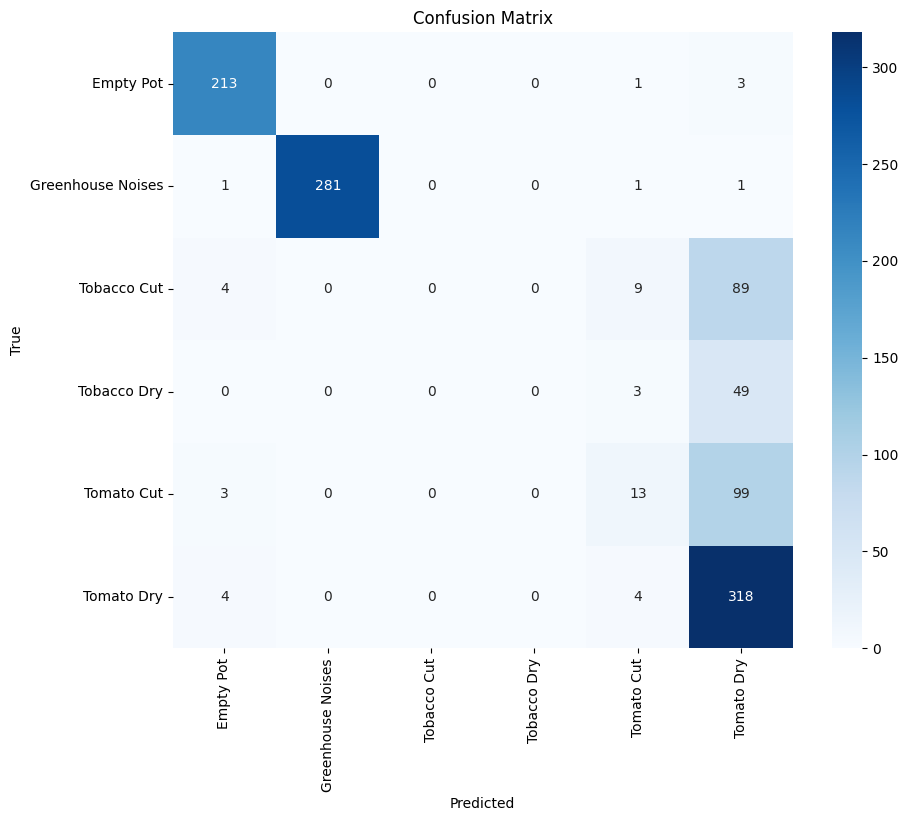

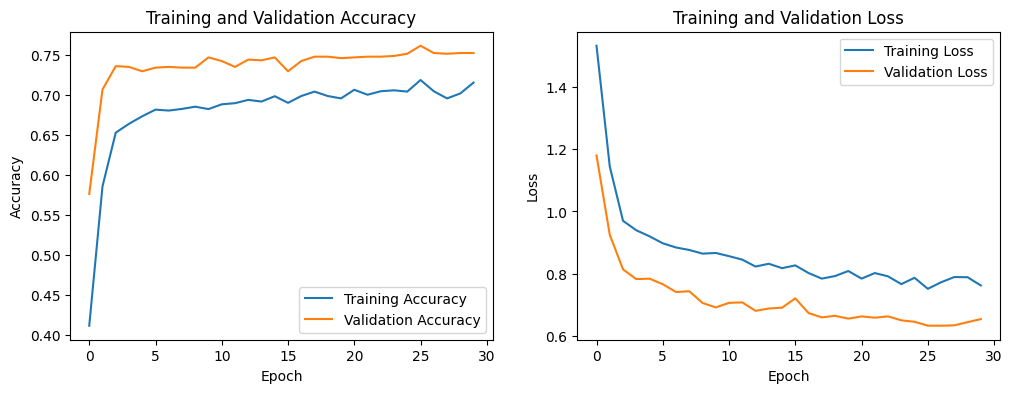

In [12]:

####pca 
import os
import random
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

# Data loading
root_dir = '/kaggle/input/spectograms'
class_names = ['Empty Pot', 'Greenhouse Noises', 'Tobacco Cut', 'Tobacco Dry', 'Tomato Cut', 'Tomato Dry']
spectrogram_paths = []
Y = []

for idx, class_name in enumerate(class_names):
    class_path = os.path.join(root_dir, class_name)
    for root, _, files in os.walk(class_path):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                spectrogram_paths.append(os.path.join(root, file))
                Y.append(idx)

Y = np.array(Y)
Y_categorical = tf.keras.utils.to_categorical(Y, num_classes=len(class_names))
label_encoder = {i: name for i, name in enumerate(class_names)}

# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Load features for clustering (raw features for PCA)
def load_spectrogram_image(file_path):
    try:
        img = plt.imread(file_path)
        if img.size == 0:
            raise ValueError(f"Empty image loaded from {file_path}")
        if len(img.shape) == 3 and img.shape[-1] in [3, 4]:
            img = np.mean(img, axis=-1)
        img = np.expand_dims(img, axis=-1)
        img = tf.image.resize(img, [64, 64]).numpy()
        return img.flatten()
    except Exception as e:
        print(f"Error loading image {file_path}: {e}")
        return None

spectrogram_features = []
valid_paths = []
valid_indices = []
for idx, path in enumerate(spectrogram_paths):
    features = load_spectrogram_image(path)
    if features is not None:
        spectrogram_features.append(features)
        valid_paths.append(path)
        valid_indices.append(idx)

spectrogram_features = np.array(spectrogram_features)
if spectrogram_features.size == 0:
    raise ValueError("No valid spectrogram features extracted")

spectrogram_paths = valid_paths
Y = Y[valid_indices]
Y_categorical = Y_categorical[valid_indices]

# Apply PCA to spectrogram features
print("Applying PCA to spectrogram features...")
pca = PCA(n_components=0.95, random_state=42)  # Retain 95% variance
spectrogram_features_pca = pca.fit_transform(spectrogram_features)
spectrogram_features_reconstructed = pca.inverse_transform(spectrogram_features_pca)
n_components = spectrogram_features_pca.shape[1]
print(f"PCA reduced dimensions to {n_components} components (from {spectrogram_features.shape[1]})")

# Reshape reconstructed features for CNN
X_spectrograms = spectrogram_features_reconstructed.reshape(-1, 64, 64, 1)

# Global normalization
X_spectrograms = (X_spectrograms - X_spectrograms.mean()) / (X_spectrograms.std() + 1e-10)

# K-Means clustering on PCA features
n_clusters = 6
print(f"n_clusters: {n_clusters}")
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(spectrogram_features_pca)
cluster_labels_categorical = tf.keras.utils.to_categorical(cluster_labels, num_classes=n_clusters)

# Split data
X_train, X_test, Y_train, Y_test, cluster_train, cluster_test = train_test_split(
    X_spectrograms, Y_categorical, cluster_labels_categorical, test_size=0.2, random_state=42
)

# Debug shapes
print(f"X_train shape: {X_train.shape}")
print(f"Y_train shape: {Y_train.shape}")
print(f"cluster_train shape: {cluster_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"Y_test shape: {Y_test.shape}")
print(f"cluster_test shape: {cluster_test.shape}")

# Build enhanced CNN model
def build_cnn_model_with_clustering(input_shape, num_classes, n_clusters):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(inputs)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.25)(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.25)(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.25)(x)
    x = layers.Conv2D(256, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)  # Added layer
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.25)(x)
    x = layers.Flatten()(x)
    clustering_features = layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    classification_output = layers.Dropout(0.4)(clustering_features)
    classification_output = layers.Dense(num_classes, activation='softmax', name='classification_output')(classification_output)
    clustering_output = layers.Dense(n_clusters, activation='softmax', name='clustering_output')(clustering_features)
    return models.Model(inputs=inputs, outputs=[classification_output, clustering_output])

input_shape = (64, 64, 1)
num_classes = 6
model = build_cnn_model_with_clustering(input_shape, num_classes, n_clusters)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
    loss={'classification_output': 'categorical_crossentropy', 'clustering_output': 'categorical_crossentropy'},
    loss_weights={'classification_output': 1.0, 'clustering_output': 0.05},  # Reduced clustering loss weight
    metrics={'classification_output': ['accuracy'],
             'clustering_output': ['accuracy']}
)
print("Compiled metrics:", model.metrics_names)

# Data Generator
def data_generator(X, Y, cluster_labels, batch_size, datagen, shuffle=True):
    num_samples = len(X)
    indices = np.arange(num_samples)
    while True:
        if shuffle:
            np.random.shuffle(indices)
        for start_idx in range(0, num_samples, batch_size):
            batch_indices = indices[start_idx:start_idx + batch_size]
            if len(batch_indices) < batch_size and start_idx + batch_size <= num_samples:
                continue
            X_batch = X[batch_indices]
            Y_batch = Y[batch_indices]
            cluster_batch = cluster_labels[batch_indices]
            X_batch_aug = np.zeros_like(X_batch)
            for i in range(len(X_batch)):
                X_batch_aug[i] = datagen.random_transform(X_batch[i])
            yield X_batch_aug, {'classification_output': Y_batch, 'clustering_output': cluster_batch}

batch_size = 32
steps_per_epoch = (len(X_train) // batch_size) or 1
history = model.fit(
    data_generator(X_train, Y_train, cluster_train, batch_size, datagen),
    steps_per_epoch=steps_per_epoch,
    epochs=30,  # Increased epochs
    validation_data=(X_test, {'classification_output': Y_test, 'clustering_output': cluster_test}),
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_classification_output_loss', patience=7, restore_best_weights=True, mode='min'),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_classification_output_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)
    ]
)

# Debug history.history keys
print("Available keys in history.history:", history.history.keys())

# Compute cumulative accuracies with fallback
try:
    cumulative_train_accuracy = np.mean(history.history['classification_output_accuracy'])
    cumulative_val_accuracy = np.mean(history.history['val_classification_output_accuracy'])
except KeyError:
    possible_train_keys = [key for key in history.history.keys() if 'classification_output' in key and 'accuracy' in key and 'val' not in key]
    possible_val_keys = [key for key in history.history.keys() if 'val_classification_output' in key and 'accuracy' in key]
    if possible_train_keys and possible_val_keys:
        train_key = possible_train_keys[0]
        val_key = possible_val_keys[0]
        print(f"Using alternative metric keys - Training: {train_key}, Validation: {val_key}")
        cumulative_train_accuracy = np.mean(history.history[train_key])
        cumulative_val_accuracy = np.mean(history.history[val_key])
    else:
        print("Manually evaluating training and validation accuracy...")
        train_results = model.evaluate(X_train, {'classification_output': Y_train, 'clustering_output': cluster_train}, verbose=0)
        val_results = model.evaluate(X_test, {'classification_output': Y_test, 'clustering_output': cluster_test}, verbose=0)
        train_accuracy_idx = None
        val_accuracy_idx = None
        for i, metric_name in enumerate(model.metrics_names):
            if 'classification_output' in metric_name and 'loss' in metric_name:
                train_accuracy_idx = i + 1
                val_accuracy_idx = i + 1
                break
        cumulative_train_accuracy = train_results[train_accuracy_idx] if train_accuracy_idx is not None else 0.0
        cumulative_val_accuracy = val_results[val_accuracy_idx] if val_accuracy_idx is not None else 0.0

print(f"Cumulative Training Accuracy (across epochs): {cumulative_train_accuracy:.4f}")
print(f"Cumulative Validation Accuracy (across epochs): {cumulative_val_accuracy:.4f}")

# Evaluate and get test accuracy
print(f"Model metrics names: {model.metrics_names}")
test_results = model.evaluate(X_test, {'classification_output': Y_test, 'clustering_output': cluster_test}, verbose=0)
classification_output_idx = None
for i, metric_name in enumerate(model.metrics_names):
    if 'classification_output' in metric_name and 'loss' in metric_name:
        classification_output_idx = i + 1
        break
if classification_output_idx is not None and classification_output_idx < len(test_results):
    test_accuracy = test_results[classification_output_idx]
    print(f"Test Accuracy (cumulative over test set): {test_accuracy:.4f}")
else:
    raise ValueError(f"Could not determine classification output accuracy from {model.metrics_names}.")

# Confusion matrix and plots
Y_pred, _ = model.predict(X_test)
Y_pred_classes = np.argmax(Y_pred, axis=1)
Y_test_classes = np.argmax(Y_test, axis=1)
cm = confusion_matrix(Y_test_classes, Y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history.get('classification_output_accuracy', history.history.get(list(history.history.keys())[0], [])), label='Training Accuracy')
plt.plot(history.history.get('val_classification_output_accuracy', history.history.get(list(history.history.keys())[1], [])), label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.subplot(1, 2, 2)
plt.plot(history.history['classification_output_loss'], label='Training Loss')
plt.plot(history.history['val_classification_output_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

Applying PCA to spectrogram features...
PCA reduced dimensions to 283 components (from 4096)
X_train shape: (4381, 64, 64, 1)
Y_train shape: (4381, 6)
X_test shape: (1096, 64, 64, 1)
Y_test shape: (1096, 6)
Compiled metrics: ['loss', 'compile_metrics']

Epoch 1: Learning rate is 0.000200
Epoch 1/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 14s 33ms/step - accuracy: 0.2867 - loss: 16.1188 - val_accuracy: 0.1980 - val_loss: 16.1710

Epoch 2: Learning rate is 0.000400
Epoch 2/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - accuracy: 0.4925 - loss: 13.9492 - val_accuracy: 0.1989 - val_loss: 18.7941

Epoch 3: Learning rate is 0.000600
Epoch 3/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.5437 - loss: 12.9274 - val_accuracy: 0.6496 - val_loss: 12.2599

Epoch 4: Learning rate is 0.000800
Epoch 4/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.5497 - loss: 12.1354 - val_accuracy: 0.7281 - val_loss: 11.7950

Epoch 5: Learning rate is 0.001000
Epoch 5/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 2s

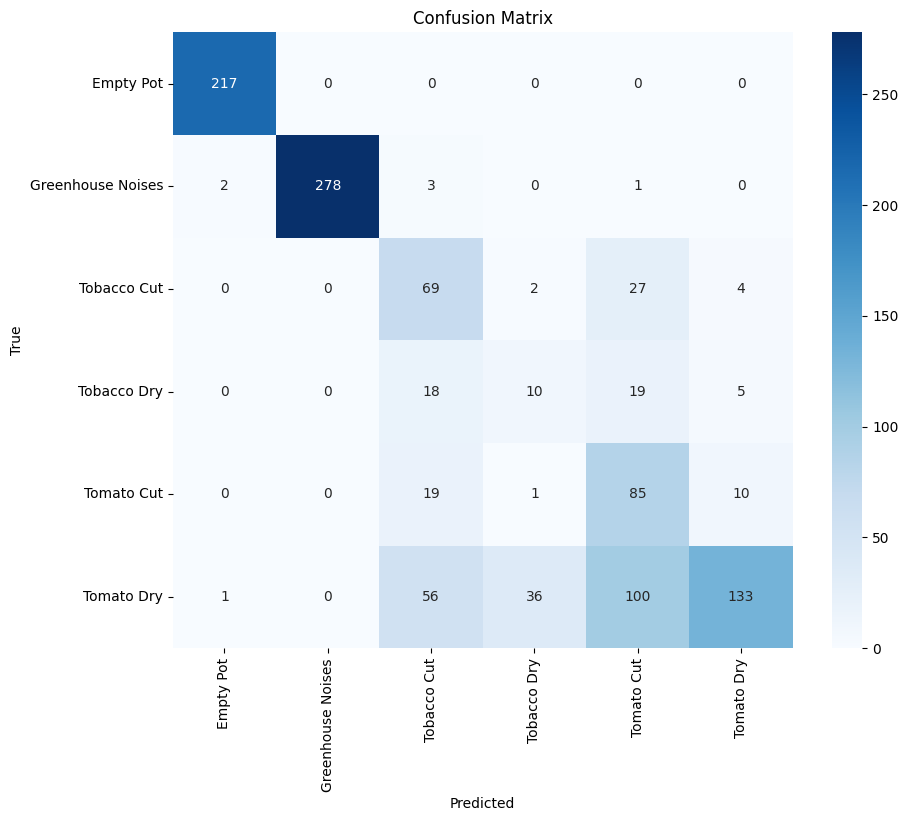

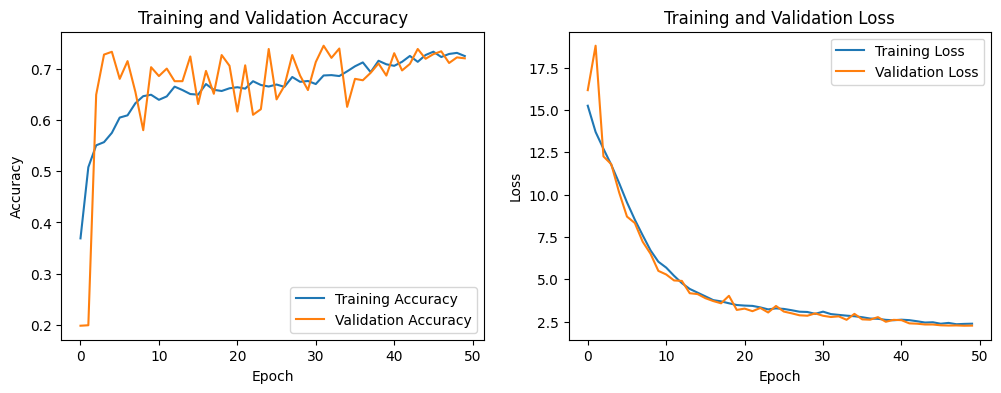

In [13]:
#without clustered CNN
import os
import random
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow_io as tfio

# Custom learning rate scheduler
class WarmUpCosineDecayScheduler(tf.keras.callbacks.Callback):
    def __init__(self, initial_lr, warmup_epochs, decay_epochs, min_lr):
        super(WarmUpCosineDecayScheduler, self).__init__()
        self.initial_lr = initial_lr
        self.warmup_epochs = warmup_epochs
        self.decay_epochs = decay_epochs
        self.min_lr = min_lr
        self.total_epochs = warmup_epochs + decay_epochs

    def on_epoch_begin(self, epoch, logs=None):
        if epoch < self.warmup_epochs:
            lr = self.initial_lr * (epoch + 1) / self.warmup_epochs
        else:
            progress = (epoch - self.warmup_epochs) / self.decay_epochs
            lr = self.min_lr + 0.5 * (self.initial_lr - self.min_lr) * (1 + np.cos(np.pi * progress))
        self.model.optimizer.learning_rate.assign(lr)
        print(f"\nEpoch {epoch + 1}: Learning rate is {lr:.6f}")

# Data loading
root_dir = '/kaggle/input/spectograms'
class_names = ['Empty Pot', 'Greenhouse Noises', 'Tobacco Cut', 'Tobacco Dry', 'Tomato Cut', 'Tomato Dry']
spectrogram_paths = []
Y = []

for idx, class_name in enumerate(class_names):
    class_path = os.path.join(root_dir, class_name)
    for root, _, files in os.walk(class_path):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                spectrogram_paths.append(os.path.join(root, file))
                Y.append(idx)

Y = np.array(Y)
Y_categorical = tf.keras.utils.to_categorical(Y, num_classes=len(class_names))
label_encoder = {i: name for i, name in enumerate(class_names)}

# Compute class weights
class_weights = np.sum(Y) / (len(class_names) * np.bincount(Y))
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}
class_weights_tensor = tf.constant([class_weights_dict[i] for i in range(len(class_names))], dtype=tf.float32)

# Custom weighted loss function
def weighted_categorical_crossentropy(y_true, y_pred):
    class_indices = tf.argmax(y_true, axis=-1)
    weights = tf.gather(class_weights_tensor, class_indices)
    loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
    weighted_loss = loss * weights
    return tf.reduce_mean(weighted_loss)

# Custom preprocessing function combining freq and time masking
def advanced_augmentation(img):
    img = tf.cast(img, tf.float32)
    if np.random.random() < 0.5:
        img = tfio.audio.freq_masking(img, param=8)
    if np.random.random() < 0.5:
        img = tfio.audio.time_masking(img, param=8)
    return img.numpy()

# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest',
    preprocessing_function=advanced_augmentation
)

# Load features for clustering (raw features for PCA)
def load_spectrogram_image(file_path):
    try:
        img = plt.imread(file_path)
        if img.size == 0:
            raise ValueError(f"Empty image loaded from {file_path}")
        if len(img.shape) == 3 and img.shape[-1] in [3, 4]:
            img = np.mean(img, axis=-1)
        img = np.expand_dims(img, axis=-1)
        img = tf.image.resize(img, [64, 64]).numpy()
        return img.flatten()
    except Exception as e:
        print(f"Error loading image {file_path}: {e}")
        return None

spectrogram_features = []
valid_paths = []
valid_indices = []
for idx, path in enumerate(spectrogram_paths):
    features = load_spectrogram_image(path)
    if features is not None:
        spectrogram_features.append(features)
        valid_paths.append(path)
        valid_indices.append(idx)

spectrogram_features = np.array(spectrogram_features)
if spectrogram_features.size == 0:
    raise ValueError("No valid spectrogram features extracted")

spectrogram_paths = valid_paths
Y = Y[valid_indices]
Y_categorical = Y_categorical[valid_indices]

# Apply PCA to spectrogram features
print("Applying PCA to spectrogram features...")
pca = PCA(n_components=0.95, random_state=42)
spectrogram_features_pca = pca.fit_transform(spectrogram_features)
spectrogram_features_reconstructed = pca.inverse_transform(spectrogram_features_pca)
n_components = spectrogram_features_pca.shape[1]
print(f"PCA reduced dimensions to {n_components} components (from {spectrogram_features.shape[1]})")

# Reshape reconstructed features for CNN
X_spectrograms = spectrogram_features_reconstructed.reshape(-1, 64, 64, 1)

# Global normalization
X_spectrograms = (X_spectrograms - X_spectrograms.mean()) / (X_spectrograms.std() + 1e-10)

# Split data
X_train, X_test, Y_train, Y_test = train_test_split(
    X_spectrograms, Y_categorical, test_size=0.2, random_state=42
)

# Debug shapes
print(f"X_train shape: {X_train.shape}")
print(f"Y_train shape: {Y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"Y_test shape: {Y_test.shape}")

# Build adjusted CNN model with fewer pooling layers
def build_cnn_model(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.01))(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    return models.Model(inputs=inputs, outputs=outputs)

input_shape = (64, 64, 1)
num_classes = 6
model = build_cnn_model(input_shape, num_classes)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=weighted_categorical_crossentropy,
    metrics=['accuracy']
)
print("Compiled metrics:", model.metrics_names)

# Data Generator
def data_generator(X, Y, batch_size, datagen, shuffle=True):
    num_samples = len(X)
    indices = np.arange(num_samples)
    while True:
        if shuffle:
            np.random.shuffle(indices)
        for start_idx in range(0, num_samples, batch_size):
            batch_indices = indices[start_idx:start_idx + batch_size]
            if len(batch_indices) < batch_size and start_idx + batch_size <= num_samples:
                continue
            X_batch = X[batch_indices]
            Y_batch = Y[batch_indices]
            X_batch_aug = np.zeros_like(X_batch)
            for i in range(len(X_batch)):
                X_batch_aug[i] = datagen.random_transform(X_batch[i])
            yield X_batch_aug, Y_batch

batch_size = 32
steps_per_epoch = (len(X_train) // batch_size) or 1
history = model.fit(
    data_generator(X_train, Y_train, batch_size, datagen),
    steps_per_epoch=steps_per_epoch,
    epochs=50,
    validation_data=(X_test, Y_test),
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, mode='min'),
        WarmUpCosineDecayScheduler(initial_lr=0.001, warmup_epochs=5, decay_epochs=45, min_lr=1e-6)
    ]
)

# Debug history.history keys
print("Available keys in history.history:", history.history.keys())

# Compute cumulative accuracies
cumulative_train_accuracy = np.mean(history.history['accuracy'])
cumulative_val_accuracy = np.mean(history.history['val_accuracy'])
print(f"Cumulative Training Accuracy (across epochs): {cumulative_train_accuracy:.4f}")
print(f"Cumulative Validation Accuracy (across epochs): {cumulative_val_accuracy:.4f}")

# Evaluate and get test accuracy
print(f"Model metrics names: {model.metrics_names}")
test_loss, test_accuracy = model.evaluate(X_test, Y_test, verbose=0)
print(f"Test Accuracy (cumulative over test set): {test_accuracy:.4f}")

# Confusion matrix and plots
Y_pred = model.predict(X_test)
Y_pred_classes = np.argmax(Y_pred, axis=1)
Y_test_classes = np.argmax(Y_test, axis=1)
cm = confusion_matrix(Y_test_classes, Y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

In [14]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from PIL import Image
import random

# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

# ===========================
# 1. Black Widow Optimization (BWO)
# ===========================
class BWO:
    def __init__(self, pop_size, mutation_rate, generations, feature_dim):
        self.pop_size = pop_size
        self.mutation_rate = mutation_rate
        self.generations = generations
        self.feature_dim = feature_dim

    def initialize_population(self):
        return np.random.rand(self.pop_size, self.feature_dim)

    def widow_elimination(self, population):
        return population[:len(population)//2]

    def mutation(self, population):
        for i in range(len(population)):
            if np.random.rand() < self.mutation_rate:
                population[i] += np.random.normal(0, 0.1, size=self.feature_dim)
                population[i] = np.clip(population[i], 0, 1)  # Prevent NaN/inf
        return population

    def optimize(self, X, y):
        population = self.initialize_population()
        for _ in range(self.generations):
            population = self.widow_elimination(population)
            population = self.mutation(population)
        weights = np.mean(population, axis=0)
        weights = np.nan_to_num(weights, nan=0.0, posinf=0.0, neginf=0.0)
        # Normalize weights and add small constant to avoid zeroing features
        weights = (weights + 1e-6) / (np.max(weights) + 1e-6)
        return weights

# ===========================
# 2. Load Spectrogram Files & Labels
# ===========================
root_dir = '/kaggle/input/spectograms'
class_names = ['Empty Pot', 'Greenhouse Noises', 'Tobacco Cut', 'Tobacco Dry', 'Tomato Cut', 'Tomato Dry']
spectrogram_size = (64, 64)

# Load spectrograms and labels
spectrogram_features = []
labels = []

for class_idx, class_name in enumerate(class_names):
    class_dir = os.path.join(root_dir, class_name)
    if not os.path.exists(class_dir):
        raise FileNotFoundError(f"Directory {class_dir} not found. Please check the path.")
    class_files = []
    for file_name in os.listdir(class_dir):
        file_path = os.path.join(class_dir, file_name)
        try:
            if file_name.endswith(('.png', '.jpg', '.jpeg')):
                img = Image.open(file_path).convert('L')
                img = img.resize(spectrogram_size)
                img_array = np.array(img) / 255.0  # Normalize to [0, 1]
                class_files.append(img_array.flatten())
                labels.append(class_idx)
            elif file_name.endswith('.npy'):
                img_array = np.load(file_path)
                if img_array.shape != spectro_size:
                    img_array = tf.image.resize(img_array, spectro_size).numpy()
                img_array = img_array / (np.max(img_array) + 1e-10)  # Avoid division by zero
                class_files.append(img_array.flatten())
                labels.append(class_idx)
        except Exception as e:
            print(f"Error loading {file_path}: {e}")
            continue
    print(f"Loaded {len(class_files)} samples for class {class_name}")
    spectrogram_features.extend(class_files)

spectrogram_features = np.array(spectrogram_features)  # Shape: (num_samples, 64*64)
labels = np.array(labels)  # Shape: (num_samples,)

# Check data size
if len(spectrogram_features) < 2:
    raise ValueError("Insufficient samples loaded. Need at least 2 samples.")

# Handle NaN/inf and outliers
print("Checking for NaN/inf in spectrogram_features...")
if np.any(np.isnan(spectrogram_features)) or np.any(np.isinf(spectrogram_features)):
    print("NaN or inf detected. Applying imputation...")
    imputer = SimpleImputer(strategy='mean')
    spectrogram_features = imputer.fit_transform(spectrogram_features)
# Clip outliers to prevent extreme values
spectrogram_features = np.clip(spectrogram_features, -1e3, 1e3)

# Check feature variance
feature_variance = np.var(spectrogram_features, axis=0)
if np.all(feature_variance < 1e-6):
    print("Warning: Features have near-zero variance. Clustering may fail.")

# Convert labels to categorical
Y_categorical = tf.keras.utils.to_categorical(labels, num_classes=len(class_names))

# Reshape for CNN
X_spectrograms = spectrogram_features.reshape(-1, 64, 64, 1)  # Shape: (num_samples, 64, 64, 1)

# Stratified train-test split
X_train, X_test, Y_train, Y_test, Y_cat_train, Y_cat_test = train_test_split(
    X_spectrograms, labels, Y_categorical, test_size=0.2, random_state=42, stratify=labels
)

# Check class distribution
print("Training set class distribution:", np.bincount(Y_train))
print("Test set class distribution:", np.bincount(Y_test))

# ===========================
# 3. Optimize Features using BWO
# ===========================
bwo = BWO(pop_size=20, mutation_rate=0.2, generations=10, feature_dim=spectrogram_features.shape[1])
optimized_weights = bwo.optimize(spectrogram_features, labels)
# Check for NaN/inf in weights
if np.any(np.isnan(optimized_weights)) or np.any(np.isinf(optimized_weights)):
    print("NaN or inf in optimized_weights. Replacing with zeros...")
    optimized_weights = np.nan_to_num(optimized_weights, nan=0.0, posinf=0.0, neginf=0.0)

weighted_features = spectrogram_features * optimized_weights

# Scale features for clustering
scaler = StandardScaler()
weighted_features = scaler.fit_transform(weighted_features)

# Handle NaN/inf in weighted_features
if np.any(np.isnan(weighted_features)) or np.any(np.isinf(weighted_features)):
    print("NaN or inf in weighted_features. Applying imputation...")
    imputer = SimpleImputer(strategy='mean')
    weighted_features = imputer.fit_transform(weighted_features)

# ===========================
# 4. Apply K-Means Clustering
# ===========================
print("Applying K-Means clustering on weighted features...")
n_clusters = min(6, len(spectrogram_features) - 1)  # Adjust if too few samples
kmeans = KMeans(n_clusters=n_clusters, n_init=20, random_state=42)
cluster_labels = kmeans.fit_predict(weighted_features)
cluster_labels_categorical = tf.keras.utils.to_categorical(cluster_labels, num_classes=n_clusters)

# Check number of unique clusters
unique_clusters = len(np.unique(cluster_labels))
print(f"Number of unique clusters: {unique_clusters}")
if unique_clusters < 2:
    print("Warning: Only one cluster formed. Silhouette score cannot be computed.")

# Split cluster labels
cluster_cat_train, cluster_cat_test = train_test_split(
    cluster_labels_categorical, test_size=0.2, random_state=42, stratify=cluster_labels
)

# ===========================
# 5. Build Simplified Clustered CNN Model
# ===========================
def build_clustered_cnn(input_shape, num_classes, n_clusters):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(16, (3,3), activation='relu')(inputs)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Conv2D(32, (3,3), activation='relu')(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Flatten()(x)
    clustering_features = layers.Dense(64, activation='relu')(x)
    classification_output = layers.Dense(num_classes, activation='softmax', name='classification_output')(clustering_features)
    clustering_output = layers.Dense(n_clusters, activation='softmax', name='clustering_output')(clustering_features)
    return models.Model(inputs=inputs, outputs=[classification_output, clustering_output])

input_shape = (64, 64, 1)
num_classes = 6
model = build_clustered_cnn(input_shape, num_classes, n_clusters)

# ===========================
# 6. Compile & Train CNN
# ===========================
model.compile(
    optimizer='adam',
    loss={'classification_output': 'categorical_crossentropy', 'clustering_output': 'categorical_crossentropy'},
    loss_weights={'classification_output': 1.0, 'clustering_output': 0.05},
    metrics={'classification_output': ['accuracy'], 'clustering_output': ['accuracy']}
)

model.fit(
    X_train, 
    {'classification_output': Y_cat_train, 'clustering_output': cluster_cat_train}, 
    validation_data=(X_test, {'classification_output': Y_cat_test, 'clustering_output': cluster_cat_test}),
    epochs=150,
    batch_size=16,
    verbose=1
)

# ===========================
# 7. Performance Metrics Calculation
# ===========================
# Clustering Metrics
silhouette = -1.0  # Default if not computed
if unique_clusters >= 2:
    silhouette = silhouette_score(weighted_features, cluster_labels)
    print(f"Silhouette Score (Clustering): {silhouette:.4f}")
else:
    print("Silhouette Score not computed due to single cluster.")
ari = adjusted_rand_score(labels, cluster_labels)
print(f"Adjusted Rand Index (ARI): {ari:.4f}")

# Classification Metrics
y_pred = np.argmax(model.predict(X_test)[0], axis=1)
y_true = np.argmax(Y_cat_test, axis=1)
conf_matrix = confusion_matrix(y_true, y_pred)
report = classification_report(y_true, y_pred, target_names=class_names, labels=range(len(class_names)))

# Print Metrics
print("\n### Classification Metrics ###")
print("Confusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(report)

Loaded 1036 samples for class Empty Pot
Loaded 1378 samples for class Greenhouse Noises
Loaded 506 samples for class Tobacco Cut
Loaded 275 samples for class Tobacco Dry
Loaded 660 samples for class Tomato Cut
Loaded 1622 samples for class Tomato Dry
Checking for NaN/inf in spectrogram_features...
Training set class distribution: [ 829 1102  405  220  528 1297]
Test set class distribution: [207 276 101  55 132 325]


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


Applying K-Means clustering on weighted features...
Number of unique clusters: 6
Epoch 1/150
274/274 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - classification_output_accuracy: 0.5429 - classification_output_loss: 1.2736 - clustering_output_accuracy: 0.1781 - clustering_output_loss: 0.0912 - loss: 1.3648 - val_classification_output_accuracy: 0.7363 - val_classification_output_loss: 0.7113 - val_clustering_output_accuracy: 0.2272 - val_clustering_output_loss: 0.0854 - val_loss: 0.7959
Epoch 2/150
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - classification_output_accuracy: 0.7432 - classification_output_loss: 0.6806 - clustering_output_accuracy: 0.2505 - clustering_output_loss: 0.0856 - loss: 0.7662 - val_classification_output_accuracy: 0.7354 - val_classification_output_loss: 0.6619 - val_clustering_output_accuracy: 0.2427 - val_clustering_output_loss: 0.0866 - val_loss: 0.7490
Epoch 3/150
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - classification_output_accuracy: 0.7562 - classification_output_lo

Loaded 1036 samples for class Empty Pot (expected 1036)
Loaded 1378 samples for class Greenhouse Noises (expected 1378)
Loaded 506 samples for class Tobacco Cut (expected 506)
Loaded 275 samples for class Tobacco Dry (expected 275)
Loaded 660 samples for class Tomato Cut (expected 660)
Loaded 1622 samples for class Tomato Dry (expected 1622)

Loaded sample counts per class:
Empty Pot: 1036 (expected 1036)
Greenhouse Noises: 1378 (expected 1378)
Tobacco Cut: 506 (expected 506)
Tobacco Dry: 275 (expected 275)
Tomato Cut: 660 (expected 660)
Tomato Dry: 1622 (expected 1622)
Total loaded samples: 5477 (expected 5477)
Sample count matches expected.
Checking for NaN/inf in spectrogram_features...
Applying SMOTE to oversample Tobacco Dry...


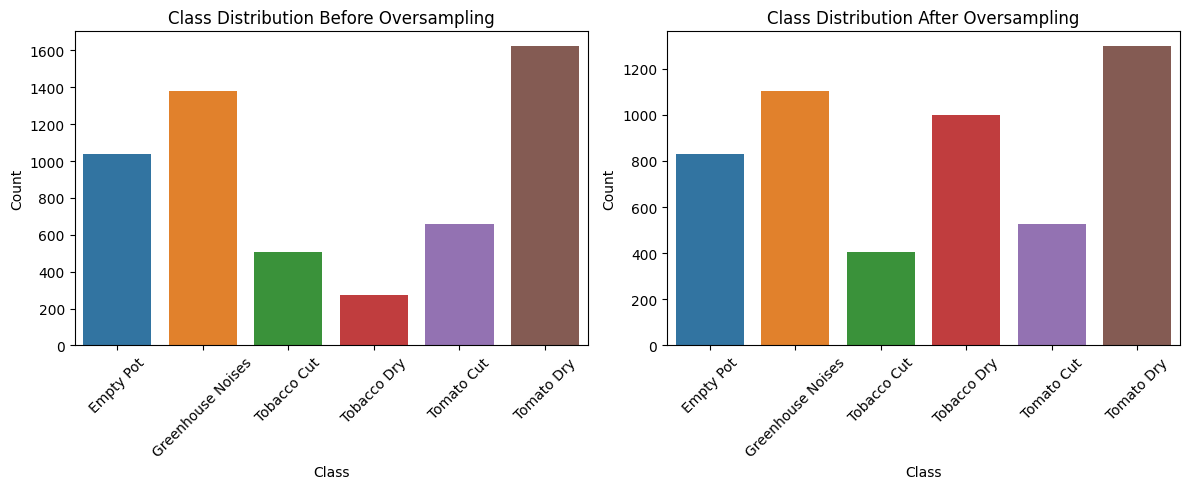

Training set class distribution (after SMOTE): [ 829 1102  405 1000  528 1297]
Test set class distribution: [207 276 101  55 132 325]


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


Applying K-Means clustering on weighted features...
Number of unique clusters (original): 6
X_train_resampled shape: (5161, 64, 64, 1)
Y_cat_train_resampled shape: (5161, 6)
cluster_cat_train shape: (5161, 6)
X_test shape: (1096, 64, 64, 1)
Y_cat_test shape: (1096, 6)
cluster_cat_test shape: (1096, 6)
Epoch 1/150
323/323 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - classification_output_accuracy: 0.4540 - classification_output_loss: 1.3792 - clustering_output_accuracy: 0.3593 - clustering_output_loss: 0.0742 - loss: 1.4534 - val_classification_output_accuracy: 0.7053 - val_classification_output_loss: 0.7600 - val_clustering_output_accuracy: 0.2144 - val_clustering_output_loss: 0.1572 - val_loss: 0.9170
Epoch 2/150
323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - classification_output_accuracy: 0.6638 - classification_output_loss: 0.8160 - clustering_output_accuracy: 0.6420 - clustering_output_loss: 0.0405 - loss: 0.8565 - val_classification_output_accuracy: 0.7290 - val_classification_output_loss: 0.

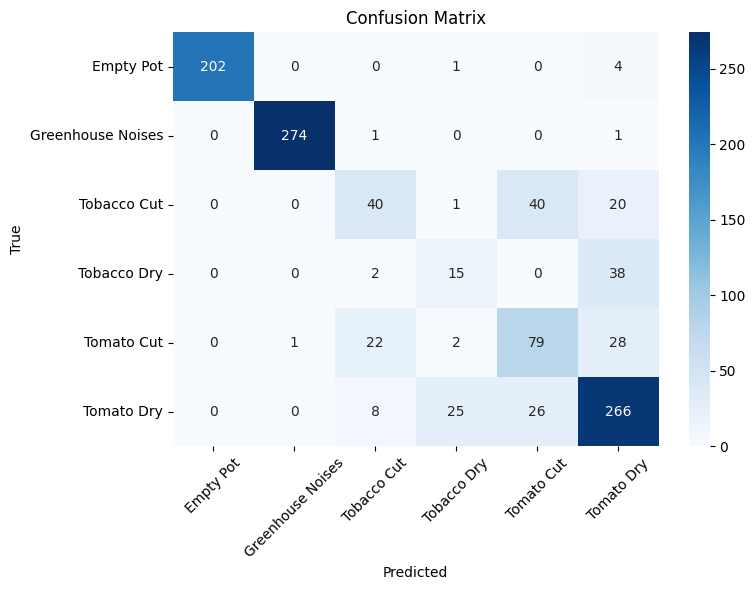


### Classification Metrics ###
Confusion Matrix:
[[202   0   0   1   0   4]
 [  0 274   1   0   0   1]
 [  0   0  40   1  40  20]
 [  0   0   2  15   0  38]
 [  0   1  22   2  79  28]
 [  0   0   8  25  26 266]]

Classification Report:
                   precision    recall  f1-score   support

        Empty Pot       1.00      0.98      0.99       207
Greenhouse Noises       1.00      0.99      0.99       276
      Tobacco Cut       0.55      0.40      0.46       101
      Tobacco Dry       0.34      0.27      0.30        55
       Tomato Cut       0.54      0.60      0.57       132
       Tomato Dry       0.75      0.82      0.78       325

         accuracy                           0.80      1096
        macro avg       0.70      0.68      0.68      1096
     weighted avg       0.79      0.80      0.79      1096



In [15]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import random

# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

# ===========================
# 1. Black Widow Optimization (BWO)
# ===========================
class BWO:
    def __init__(self, pop_size, mutation_rate, generations, feature_dim):
        self.pop_size = pop_size
        self.mutation_rate = mutation_rate
        self.generations = generations
        self.feature_dim = feature_dim

    def initialize_population(self):
        return np.random.rand(self.pop_size, self.feature_dim)

    def widow_elimination(self, population):
        return population[:len(population)//2]

    def mutation(self, population):
        for i in range(len(population)):
            if np.random.rand() < self.mutation_rate:
                population[i] += np.random.normal(0, 0.1, size=self.feature_dim)
                population[i] = np.clip(population[i], 0, 1)
        return population

    def optimize(self, X, y):
        population = self.initialize_population()
        for _ in range(self.generations):
            population = self.widow_elimination(population)
            population = self.mutation(population)
        weights = np.mean(population, axis=0)
        weights = np.nan_to_num(weights, nan=0.0, posinf=0.0, neginf=0.0)
        weights = (weights + 1e-6) / (np.max(weights) + 1e-6)
        return weights

# ===========================
# 2. Load Spectrogram Files & Labels
# ===========================
root_dir = '/kaggle/input/spectograms'
class_names = ['Empty Pot', 'Greenhouse Noises', 'Tobacco Cut', 'Tobacco Dry', 'Tomato Cut', 'Tomato Dry']
spectrogram_size = (64, 64)
expected_counts = {'Empty Pot': 1036, 'Greenhouse Noises': 1378, 'Tobacco Cut': 506, 'Tobacco Dry': 275, 'Tomato Cut': 660, 'Tomato Dry': 1622}
expected_total = sum(expected_counts.values())  # 5480

# Load spectrograms and labels
spectrogram_features = []
labels = []
failed_files = []

for class_idx, class_name in enumerate(class_names):
    class_dir = os.path.join(root_dir, class_name)
    if not os.path.exists(class_dir):
        raise FileNotFoundError(f"Directory {class_dir} not found. Please check the path.")
    class_files = []
    for file_name in os.listdir(class_dir):
        file_path = os.path.join(class_dir, file_name)
        try:
            if file_name.endswith(('.png', '.jpg', '.jpeg')):
                img = Image.open(file_path).convert('L')
                img = img.resize(spectrogram_size)
                img_array = np.array(img) / 255.0
                class_files.append(img_array.flatten())
                labels.append(class_idx)
            elif file_name.endswith('.npy'):
                img_array = np.load(file_path)
                if img_array.shape != spectrogram_size:
                    img_array = tf.image.resize(img_array, spectrogram_size).numpy()
                img_array = img_array / (np.max(img_array) + 1e-10)
                class_files.append(img_array.flatten())
                labels.append(class_idx)
            else:
                print(f"Skipping unsupported file: {file_path}")
                failed_files.append((file_path, "Unsupported format"))
        except Exception as e:
            print(f"Error loading {file_path}: {e}")
            failed_files.append((file_path, str(e)))
            continue
    print(f"Loaded {len(class_files)} samples for class {class_name} (expected {expected_counts[class_name]})")
    spectrogram_features.extend(class_files)

spectrogram_features = np.array(spectrogram_features)  # Shape: (num_samples, 64*64)
labels = np.array(labels)  # Shape: (num_samples,)

# Verify loaded samples
loaded_counts = {class_name: np.sum(labels == idx) for idx, class_name in enumerate(class_names)}
print("\nLoaded sample counts per class:")
for class_name in class_names:
    print(f"{class_name}: {loaded_counts[class_name]} (expected {expected_counts[class_name]})")
total_loaded = len(spectrogram_features)
print(f"Total loaded samples: {total_loaded} (expected {expected_total})")

# Check data size
if total_loaded < expected_total * 0.99:  # Allow 1% missing samples
    print(f"Warning: Loaded {total_loaded} samples, significantly less than expected {expected_total}. Check failed files:")
    for file_path, error in failed_files:
        print(f"  {file_path}: {error}")
elif total_loaded != expected_total:
    print(f"Warning: Loaded {total_loaded} samples, slightly less than expected {expected_total}. Proceeding with available data.")
else:
    print("Sample count matches expected.")

# Check minimum samples
if total_loaded < 2:
    raise ValueError(f"Insufficient samples loaded: {total_loaded}. Need at least 2.")

# Handle NaN/inf and outliers
print("Checking for NaN/inf in spectrogram_features...")
if np.any(np.isnan(spectrogram_features)) or np.any(np.isinf(spectrogram_features)):
    print("NaN or inf detected. Applying imputation...")
    imputer = SimpleImputer(strategy='mean')
    spectrogram_features = imputer.fit_transform(spectrogram_features)
spectrogram_features = np.clip(spectrogram_features, -1e3, 1e3)

# Check feature variance
feature_variance = np.var(spectrogram_features, axis=0)
if np.all(feature_variance < 1e-6):
    print("Warning: Features have near-zero variance. Clustering may fail.")

# Plot class distribution before oversampling
plt.figure(figsize=(12, 5))
ax = plt.subplot(1, 2, 1)
sns.countplot(x=labels)
ax.set_xticklabels(class_names, rotation=45)
plt.title("Class Distribution Before Oversampling")
plt.xlabel("Class")
plt.ylabel("Count")

# Stratified train-test split
X_train, X_test, Y_train, Y_test, Y_cat_train, Y_cat_test = train_test_split(
    spectrogram_features, labels, tf.keras.utils.to_categorical(labels, num_classes=len(class_names)),
    test_size=0.2, random_state=42, stratify=labels
)

# Apply SMOTE to oversample Tobacco Dry in training set
print("Applying SMOTE to oversample Tobacco Dry...")
smote = SMOTE(sampling_strategy={3: 1000}, random_state=42)  # Class 3: Tobacco Dry
X_train_resampled, Y_train_resampled = smote.fit_resample(X_train, Y_train)
Y_cat_train_resampled = tf.keras.utils.to_categorical(Y_train_resampled, num_classes=len(class_names))

# Reshape resampled features for CNN
X_train_resampled = X_train_resampled.reshape(-1, 64, 64, 1)
X_test = X_test.reshape(-1, 64, 64, 1)

# Plot class distribution after oversampling
ax = plt.subplot(1, 2, 2)
sns.countplot(x=Y_train_resampled)
ax.set_xticklabels(class_names, rotation=45)
plt.title("Class Distribution After Oversampling")
plt.xlabel("Class")
plt.ylabel("Count")
plt.tight_layout()
plt.savefig('class_distribution.png')
plt.show()

# Check class distribution
print("Training set class distribution (after SMOTE):", np.bincount(Y_train_resampled))
print("Test set class distribution:", np.bincount(Y_test))

# ===========================
# 3. Optimize Features using BWO
# ===========================
bwo = BWO(pop_size=20, mutation_rate=0.2, generations=10, feature_dim=spectrogram_features.shape[1])
optimized_weights = bwo.optimize(spectrogram_features, labels)
if np.any(np.isnan(optimized_weights)) or np.any(np.isinf(optimized_weights)):
    print("NaN or inf in optimized_weights. Replacing with zeros...")
    optimized_weights = np.nan_to_num(optimized_weights, nan=0.0, posinf=0.0, neginf=0.0)

# Compute weighted features
weighted_features = spectrogram_features * optimized_weights
weighted_features_train = X_train_resampled.reshape(-1, 64*64) * optimized_weights

# Scale features
scaler = StandardScaler()
weighted_features = scaler.fit_transform(weighted_features)
weighted_features_train = scaler.transform(weighted_features_train)

# Handle NaN/inf
if np.any(np.isnan(weighted_features)) or np.any(np.isinf(weighted_features)):
    print("NaN or inf in weighted_features. Applying imputation...")
    imputer = SimpleImputer(strategy='mean')
    weighted_features = imputer.fit_transform(weighted_features)
if np.any(np.isnan(weighted_features_train)) or np.any(np.isinf(weighted_features_train)):
    print("NaN or inf in weighted_features_train. Applying imputation...")
    imputer = SimpleImputer(strategy='mean')
    weighted_features_train = imputer.fit_transform(weighted_features_train)

# ===========================
# 4. Apply K-Means Clustering
# ===========================
print("Applying K-Means clustering on weighted features...")
n_clusters = min(6, len(spectrogram_features) - 1)
kmeans = KMeans(n_clusters=n_clusters, n_init=20, random_state=42)

# Cluster original features for test set
cluster_labels = kmeans.fit_predict(weighted_features)
cluster_labels_categorical = tf.keras.utils.to_categorical(cluster_labels, num_classes=n_clusters)

# Cluster resampled training features
cluster_labels_train = kmeans.predict(weighted_features_train)
cluster_labels_train_categorical = tf.keras.utils.to_categorical(cluster_labels_train, num_classes=n_clusters)

unique_clusters = len(np.unique(cluster_labels))
print(f"Number of unique clusters (original): {unique_clusters}")
if unique_clusters < 2:
    print("Warning: Only one cluster formed. Silhouette score cannot be computed.")

# Split original cluster labels for test set
_, cluster_cat_test = train_test_split(
    cluster_labels_categorical, test_size=0.2, random_state=42, stratify=cluster_labels
)

# Use resampled cluster labels for training
cluster_cat_train = cluster_labels_train_categorical

# Verify sample sizes
print(f"X_train_resampled shape: {X_train_resampled.shape}")
print(f"Y_cat_train_resampled shape: {Y_cat_train_resampled.shape}")
print(f"cluster_cat_train shape: {cluster_cat_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"Y_cat_test shape: {Y_cat_test.shape}")
print(f"cluster_cat_test shape: {cluster_cat_test.shape}")

# ===========================
# 5. Build Simplified Clustered CNN Model
# ===========================
def build_clustered_cnn(input_shape, num_classes, n_clusters):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(16, (3,3), activation='relu')(inputs)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Conv2D(32, (3,3), activation='relu')(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Flatten()(x)
    clustering_features = layers.Dense(64, activation='relu')(x)
    classification_output = layers.Dense(num_classes, activation='softmax', name='classification_output')(clustering_features)
    clustering_output = layers.Dense(n_clusters, activation='softmax', name='clustering_output')(clustering_features)
    return models.Model(inputs=inputs, outputs=[classification_output, clustering_output])

input_shape = (64, 64, 1)
num_classes = 6
model = build_clustered_cnn(input_shape, num_classes, n_clusters)

# ===========================
# 6. Compile & Train CNN
# ===========================
model.compile(
    optimizer='adam',
    loss={'classification_output': 'categorical_crossentropy', 'clustering_output': 'categorical_crossentropy'},
    loss_weights={'classification_output': 1.0, 'clustering_output': 0.05},
    metrics={'classification_output': ['accuracy'], 'clustering_output': ['accuracy']}
)

model.fit(
    X_train_resampled, 
    {'classification_output': Y_cat_train_resampled, 'clustering_output': cluster_cat_train}, 
    validation_data=(X_test, {'classification_output': Y_cat_test, 'clustering_output': cluster_cat_test}),
    epochs=150,
    batch_size=16,
    verbose=1
)

# ===========================
# 7. Performance Metrics Calculation
# ===========================
# Clustering Metrics
silhouette = -1.0
if unique_clusters >= 2:
    silhouette = silhouette_score(weighted_features, cluster_labels)
    print(f"Silhouette Score (Clustering): {silhouette:.4f}")
else:
    print("Silhouette Score not computed due to single cluster.")
ari = adjusted_rand_score(labels, cluster_labels)
print(f"Adjusted Rand Index (ARI): {ari:.4f}")

# Classification Metrics
y_pred = np.argmax(model.predict(X_test)[0], axis=1)
y_true = np.argmax(Y_cat_test, axis=1)
conf_matrix = confusion_matrix(y_true, y_pred)
report = classification_report(y_true, y_pred, target_names=class_names, labels=range(len(class_names)))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('confusion_matrix.png')
plt.show()

# Print Metrics
print("\n### Classification Metrics ###")
print("Confusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(report)

In [16]:
pip install minisom

  Preparing metadata (setup.py) ... done
  Created wheel for minisom: filename=MiniSom-2.3.5-py3-none-any.whl size=12031 sha256=66364b7f3cfcc83c26e5c1af34c92c5b0de6600b2496b7c956a402366c68f006
  Stored in directory: /root/.cache/pip/wheels/be/33/77/b6bb14008fa79a2dd2b79d565e941d5faa2d7f7526e528345b
Successfully built minisom
Note: you may need to restart the kernel to use updated packages.


Loaded 1036 samples for class Empty Pot (expected 1036)
Loaded 1378 samples for class Greenhouse Noises (expected 1378)
Loaded 506 samples for class Tobacco Cut (expected 506)
Loaded 275 samples for class Tobacco Dry (expected 275)
Loaded 660 samples for class Tomato Cut (expected 660)
Loaded 1622 samples for class Tomato Dry (expected 1622)

Loaded sample counts per class:
Empty Pot: 1036 (expected 1036)
Greenhouse Noises: 1378 (expected 1378)
Tobacco Cut: 506 (expected 506)
Tobacco Dry: 275 (expected 275)
Tomato Cut: 660 (expected 660)
Tomato Dry: 1622 (expected 1622)
Total loaded samples: 5477 (expected 5477)
Sample count matches expected.
Applying SOM for neuromorphic feature extraction...
SOM training completed.
Checking for NaN/inf in som_features...
Applying SMOTE and undersampling for class balancing...


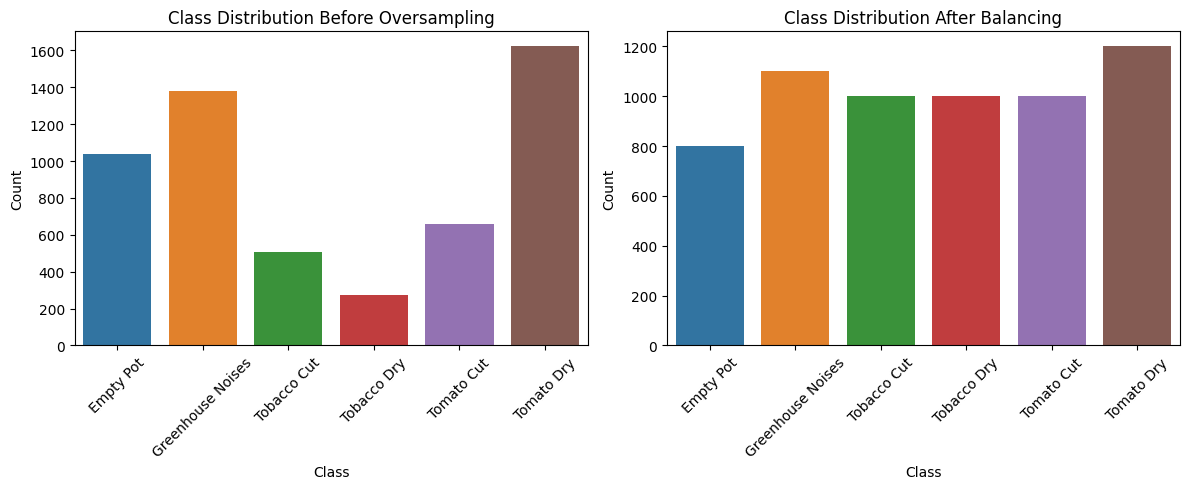

Training set class distribution (after balancing): [ 800 1100 1000 1000 1000 1200]
Test set class distribution: [207 276 101  55 132 325]
Applying K-Means clustering on SOM features...
Number of unique clusters: 6
X_train_resampled shape: (6100, 64, 64, 1)
Y_cat_train_resampled shape: (6100, 6)
cluster_cat_train shape: (6100, 6)
X_test shape: (1096, 64, 64, 1)
Y_cat_test shape: (1096, 6)
cluster_cat_test shape: (1096, 6)
Epoch 1/150
382/382 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - classification_output_accuracy: 0.3659 - classification_output_loss: 1.5161 - clustering_output_accuracy: 0.7741 - clustering_output_loss: 0.0521 - loss: 1.5682 - val_classification_output_accuracy: 0.5922 - val_classification_output_loss: 0.8898 - val_clustering_output_accuracy: 0.7746 - val_clustering_output_loss: 0.0495 - val_loss: 0.9396
Epoch 2/150
382/382 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - classification_output_accuracy: 0.5886 - classification_output_loss: 0.9243 - clustering_output_accuracy: 0.7781 - cluste

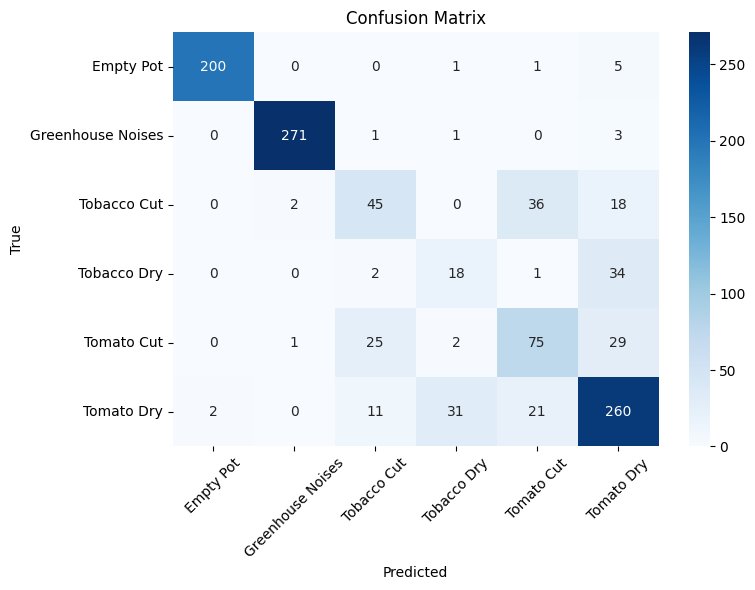


### Classification Metrics ###
Confusion Matrix:
[[200   0   0   1   1   5]
 [  0 271   1   1   0   3]
 [  0   2  45   0  36  18]
 [  0   0   2  18   1  34]
 [  0   1  25   2  75  29]
 [  2   0  11  31  21 260]]

Classification Report:
                   precision    recall  f1-score   support

        Empty Pot       0.99      0.97      0.98       207
Greenhouse Noises       0.99      0.98      0.99       276
      Tobacco Cut       0.54      0.45      0.49       101
      Tobacco Dry       0.34      0.33      0.33        55
       Tomato Cut       0.56      0.57      0.56       132
       Tomato Dry       0.74      0.80      0.77       325

         accuracy                           0.79      1096
        macro avg       0.69      0.68      0.69      1096
     weighted avg       0.79      0.79      0.79      1096



In [17]:



import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import random
from minisom import MiniSom

# Set random seeds
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

# Simulated neuromorphic cochlea
def spectrogram_to_spikes(spectrogram, num_channels=64, threshold=0.1, max_spikes=1000):
    height, width = spectrogram.shape
    spike_times = []
    spike_channels = []
    time_steps = width
    freq_bins = min(height, num_channels)
    for t in range(time_steps):
        for f in range(freq_bins):
            intensity = spectrogram[f, t]
            if intensity > threshold and random.random() < intensity:
                spike_times.append(t)
                spike_channels.append(f)
                if len(spike_times) >= max_spikes:
                    break
        if len(spike_times) >= max_spikes:
            break
    return np.array(spike_times), np.array(spike_channels)

# Load spectrograms and spikes
root_dir = '/kaggle/input/spectograms'
class_names = ['Empty Pot', 'Greenhouse Noises', 'Tobacco Cut', 'Tobacco Dry', 'Tomato Cut', 'Tomato Dry']
spectrogram_size = (64, 64)
expected_counts = {'Empty Pot': 1036, 'Greenhouse Noises': 1378, 'Tobacco Cut': 506, 'Tobacco Dry': 275, 'Tomato Cut': 660, 'Tomato Dry': 1622}
expected_total = sum(expected_counts.values())

spectrogram_features = []
labels = []
spike_features = []
failed_files = []

for class_idx, class_name in enumerate(class_names):
    class_dir = os.path.join(root_dir, class_name)
    if not os.path.exists(class_dir):
        raise FileNotFoundError(f"Directory {class_dir} not found.")
    class_files = []
    class_spikes = []
    for file_name in os.listdir(class_dir):
        file_path = os.path.join(class_dir, file_name)
        try:
            if file_name.endswith(('.png', '.jpg', '.jpeg')):
                img = Image.open(file_path).convert('L')
                img = img.resize(spectrogram_size)
                img_array = np.array(img) / 255.0
            elif file_name.endswith('.npy'):
                img_array = np.load(file_path)
                if img_array.shape != spectrogram_size:
                    img_array = tf.image.resize(img_array, spectrogram_size).numpy()
                img_array = img_array / (np.max(img_array) + 1e-10)
            else:
                print(f"Skipping unsupported file: {file_path}")
                failed_files.append((file_path, "Unsupported format"))
                continue
            spike_times, spike_channels = spectrogram_to_spikes(img_array)
            class_spikes.append((spike_times, spike_channels))
            class_files.append(img_array.flatten())
            labels.append(class_idx)
        except Exception as e:
            print(f"Error loading {file_path}: {e}")
            failed_files.append((file_path, str(e)))
            continue
    print(f"Loaded {len(class_files)} samples for class {class_name} (expected {expected_counts[class_name]})")
    spectrogram_features.extend(class_files)
    spike_features.extend(class_spikes)

spectrogram_features = np.array(spectrogram_features)
labels = np.array(labels)

# Verify loaded samples
loaded_counts = {class_name: np.sum(labels == idx) for idx, class_name in enumerate(class_names)}
print("\nLoaded sample counts per class:")
for class_name in class_names:
    print(f"{class_name}: {loaded_counts[class_name]} (expected {expected_counts[class_name]})")
total_loaded = len(spectrogram_features)
print(f"Total loaded samples: {total_loaded} (expected {expected_total})")

if total_loaded < expected_total * 0.99:
    print(f"Warning: Loaded {total_loaded} samples, significantly less than expected {expected_total}. Check failed files:")
    for file_path, error in failed_files:
        print(f"  {file_path}: {error}")
elif total_loaded != expected_total:
    print(f"Warning: Loaded {total_loaded} samples, slightly less than expected {expected_total}. Proceeding.")
else:
    print("Sample count matches expected.")

if total_loaded < 2:
    raise ValueError(f"Insufficient samples loaded: {total_loaded}. Need at least 2.")

# SOM feature extraction
print("Applying SOM for neuromorphic feature extraction...")
som_size = (10, 10)
som = MiniSom(som_size[0], som_size[1], 64, sigma=1.0, learning_rate=0.5, random_seed=42)
spike_histograms = []
for spike_times, spike_channels in spike_features:
    hist, _ = np.histogram(spike_channels, bins=64, range=(0, 64))
    spike_histograms.append(hist / (np.sum(hist) + 1e-10))
spike_histograms = np.array(spike_histograms)
som.train_random(spike_histograms, 1000)
print("SOM training completed.")

som_features = np.zeros((len(spike_histograms), som_size[0] * som_size[1]))
for i, hist in enumerate(spike_histograms):
    bmu = som.winner(hist)
    som_features[i, bmu[0] * som_size[1] + bmu[1]] = 1.0

print("Checking for NaN/inf in som_features...")
if np.any(np.isnan(som_features)) or np.any(np.isinf(som_features)):
    print("NaN or inf detected. Applying imputation...")
    imputer = SimpleImputer(strategy='mean')
    som_features = imputer.fit_transform(som_features)
som_features = np.clip(som_features, -1e3, 1e3)

scaler = StandardScaler()
som_features = scaler.fit_transform(som_features)

# Plot class distribution before oversampling
plt.figure(figsize=(12, 5))
ax = plt.subplot(1, 2, 1)
sns.countplot(x=labels)
ax.set_xticklabels(class_names, rotation=45)
plt.title("Class Distribution Before Oversampling")
plt.xlabel("Class")
plt.ylabel("Count")

# Train-test split
X_train, X_test, Y_train, Y_test, Y_cat_train, Y_cat_test = train_test_split(
    spectrogram_features, labels, tf.keras.utils.to_categorical(labels, num_classes=len(class_names)),
    test_size=0.2, random_state=42, stratify=labels
)
som_features_train, som_features_test = train_test_split(
    som_features, test_size=0.2, random_state=42, stratify=labels
)

# Apply SMOTE and undersampling
print("Applying SMOTE and undersampling for class balancing...")
over_strategy = {2: 1000, 3: 1000, 4: 1000}  # Tobacco Cut, Tobacco Dry, Tomato Cut
under_strategy = {0: 800, 1: 1100, 5: 1200}  # Empty Pot, Greenhouse Noises, Tomato Dry
balancing_pipeline = Pipeline([
    ('smote', SMOTE(sampling_strategy=over_strategy, random_state=42)),
    ('under', RandomUnderSampler(sampling_strategy=under_strategy, random_state=42))
])

X_train_resampled, Y_train_resampled = balancing_pipeline.fit_resample(X_train, Y_train)
Y_cat_train_resampled = tf.keras.utils.to_categorical(Y_train_resampled, num_classes=len(class_names))
som_features_train_resampled, _ = balancing_pipeline.fit_resample(som_features_train, Y_train)

X_train_resampled = X_train_resampled.reshape(-1, 64, 64, 1)
X_test = X_test.reshape(-1, 64, 64, 1)

# Plot class distribution after balancing
ax = plt.subplot(1, 2, 2)
sns.countplot(x=Y_train_resampled)
ax.set_xticklabels(class_names, rotation=45)
plt.title("Class Distribution After Balancing")
plt.xlabel("Class")
plt.ylabel("Count")
plt.tight_layout()
plt.savefig('class_distribution.png')
plt.show()

print("Training set class distribution (after balancing):", np.bincount(Y_train_resampled))
print("Test set class distribution:", np.bincount(Y_test))

# K-Means clustering
print("Applying K-Means clustering on SOM features...")
n_clusters = min(6, len(som_features) - 1)
kmeans = KMeans(n_clusters=n_clusters, n_init=20, random_state=42)
cluster_labels = kmeans.fit_predict(som_features)
cluster_labels_categorical = tf.keras.utils.to_categorical(cluster_labels, num_classes=n_clusters)
cluster_labels_train = kmeans.predict(som_features_train_resampled)
cluster_labels_train_categorical = tf.keras.utils.to_categorical(cluster_labels_train, num_classes=n_clusters)

unique_clusters = len(np.unique(cluster_labels))
print(f"Number of unique clusters: {unique_clusters}")
if unique_clusters < 2:
    print("Warning: Only one cluster formed. Silhouette score cannot be computed.")

_, cluster_cat_test = train_test_split(
    cluster_labels_categorical, test_size=0.2, random_state=42, stratify=cluster_labels
)
cluster_cat_train = cluster_labels_train_categorical

print(f"X_train_resampled shape: {X_train_resampled.shape}")
print(f"Y_cat_train_resampled shape: {Y_cat_train_resampled.shape}")
print(f"cluster_cat_train shape: {cluster_cat_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"Y_cat_test shape: {Y_cat_test.shape}")
print(f"cluster_cat_test shape: {cluster_cat_test.shape}")

# CNN model
def build_clustered_cnn(input_shape, num_classes, n_clusters):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(16, (3,3), activation='relu')(inputs)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Conv2D(32, (3,3), activation='relu')(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Flatten()(x)
    clustering_features = layers.Dense(64, activation='relu')(x)
    classification_output = layers.Dense(num_classes, activation='softmax', name='classification_output')(clustering_features)
    clustering_output = layers.Dense(n_clusters, activation='softmax', name='clustering_output')(clustering_features)
    return models.Model(inputs=inputs, outputs=[classification_output, clustering_output])

input_shape = (64, 64, 1)
num_classes = 6
model = build_clustered_cnn(input_shape, num_classes, n_clusters)

model.compile(
    optimizer='adam',
    loss={'classification_output': 'categorical_crossentropy', 'clustering_output': 'categorical_crossentropy'},
    loss_weights={'classification_output': 1.0, 'clustering_output': 0.05},
    metrics={'classification_output': ['accuracy'], 'clustering_output': ['accuracy']}
)

model.fit(
    X_train_resampled, 
    {'classification_output': Y_cat_train_resampled, 'clustering_output': cluster_cat_train}, 
    validation_data=(X_test, {'classification_output': Y_cat_test, 'clustering_output': cluster_cat_test}),
    epochs=150,
    batch_size=16,
    verbose=1
)

# Performance metrics
silhouette = -1.0
if unique_clusters >= 2:
    silhouette = silhouette_score(som_features, cluster_labels)
    print(f"Silhouette Score (Clustering): {silhouette:.4f}")
else:
    print("Silhouette Score not computed due to single cluster.")
ari = adjusted_rand_score(labels, cluster_labels)
print(f"Adjusted Rand Index (ARI): {ari:.4f}")

y_pred = np.argmax(model.predict(X_test)[0], axis=1)
y_true = np.argmax(Y_cat_test, axis=1)
conf_matrix = confusion_matrix(y_true, y_pred)
report = classification_report(y_true, y_pred, target_names=class_names, labels=range(len(class_names)))

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('confusion_matrix.png')
plt.show()

print("\n### Classification Metrics ###")
print("Confusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(report)